In [1]:
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install scipy
!{sys.executable} -m pip install pymc3
!{sys.executable} -m pip install seaborn

You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import pymc3 as pm
import seaborn as sns
from functions import generate_simulation_data, plot_posteriors

<p class="gap2">
<h1 style="font-weight: bold; color: #12698a">Instrumental variable analysis for advertising effectiveness<br>
</h1>

<h2 style="color: #50494e">PyMCon 2020</h2>


<p class="gap05">  </p>
<h3 style="color: #12698a">Ruben Mak <br>
Principal Data Scientist and Discovery Cluster Lead at Greenhouse</h3>
<img src="images/PyMC3_banner.svg">
</p>

## Short introduction

<p><img src="images/wpp_greenhouse.png"></p>

## Quickly some terminology
* impression: an ad is loaded once onto a webpage browsed by a user

* conversion: the desired outcome of an advertiser, for example online purchase or visiting a specific webpage on the advertiser's website

* frequency cap: a setting which determines the maximum amount of impressions a user can get of an ad

## Research question
* What is the optimal amount of impressions to maximize conversions?

## What does the data say?

<p><img src="images/optimum_plots.png"></p>

## Maybe we should draw a causal graph...

<p><img src="images/causal_graph_1.png"></p>

## Maybe we should draw a causal graph...

<p><img src="images/causal_graph_2.png"></p>

## Instrumental Variable Setup
* The golden standard, A/B test (Random Controlled Trial) doesn't work...

* But we can run a A/B/n test on the frequency cap.

* This is a perfect setting to apply instrumental variables!

## Let's complete our causal graph

<p><img src="images/causal_graph_3.png"></p>

## Research question
* What is the optimal amount of impressions to maximize conversions?

* Do we really need instrumental variables, or are we looking for the results of the A/B test instead?

In [3]:
max_cap = 7
max_impr = 7

base_conversion_probability = [0.015, 0.07, 0.07, 0.08, 0.125, 0.08, 0.04]
effects = [0.1, 0.06, 0.04, 0.025, 0.015, 0.01, 0.005]

P_potential_impressions = [0.27, 0.21, 0.19, 0.14, 0.08, 0.06, 0.05]
P_frequency_cap = [1 / max_cap] * max_cap

n_users = 10 ** 6

df = generate_simulation_data(P_potential_impressions,
                            P_frequency_cap,
                            base_conversion_probability,
                            effects,
                            n_users)

df['non_conversions'] = df['users'] - df['conversions']

In [4]:
df

users  conversions  non_conversions
frequency_cap impressions                                      
1             1            142913        22933           119980
2             1             38583         4434            34149
              2            104329        24665            79664
3             1             38656         4485            34171
              2             30062         6877            23185
              3             74453        20899            53554
4             1             38306         4458            33848
              2             29836         6737            23099
              3             27205         7313            19892
              4             47341        14565            32776
5             1             38660         4384            34276
              2             29928         6789            23139
              3             27305         7364            19941
              4             19894         6079            13815
              5             27225         8882            18343
6             1             38323         4372            33951
              2             29947         6955            22992
              3             26935         7198            19737
              4             20091         6069            14022
              5             11394         4165             7229
              6             15640         4897            10743
7             1             38849         4407            34442
              2             29961         6894            23067
              3             26830         7297            19533
              4             20167         6186            13981
              5             11485         4234             7251
              6              8496         2809             5687
              7              7186         2203             4983

In [5]:
df_impressions = df.groupby(['impressions']).sum()
df_impressions

,users,conversions,non_conversions
impressions,,,
1,374290,49473,324817
2,254063,58917,195146
3,182728,50071,132657
4,107493,32899,74594
5,50104,17281,32823
6,24136,7706,16430
7,7186,2203,4983


In [6]:
df_frequency_cap = df.groupby(['frequency_cap']).sum()
df_frequency_cap

,users,conversions,non_conversions
frequency_cap,,,
1,142913,22933,119980
2,142912,29099,113813
3,143171,32261,110910
4,142688,33073,109615
5,143012,33498,109514
6,142330,33656,108674
7,142974,34030,108944


In [7]:
n_samples = 10 ** 4

P_Y_given_X = [stats.beta.rvs(
    df_impressions['conversions'][i],
    df_impressions['non_conversions'][i],
    size = n_samples) for i in df_impressions.index]

P_Y_given_Z = [stats.beta.rvs(
    df_frequency_cap['conversions'][i],
    df_frequency_cap['non_conversions'][i],
    size = n_samples) for i in df_frequency_cap.index]

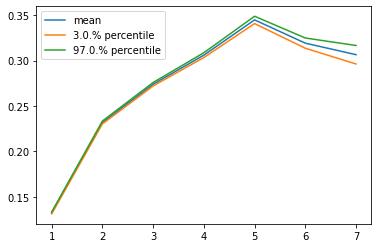

In [8]:
plot_posteriors(df_impressions.index, P_Y_given_X)

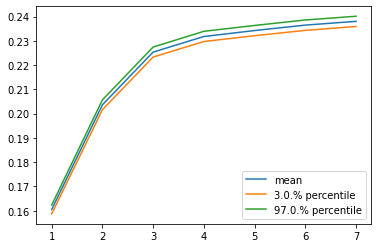

In [9]:
plot_posteriors(df_frequency_cap.index, P_Y_given_Z)

## Two stage approach

<h1><center>Stage 1: $x = c_1 + z \theta + \varepsilon_1$</center></h1>

<h1><center>Stage 2: $y = c_2 + \hat{x} \beta + \varepsilon_2$</center></h1>

<h1><center>$\hat{x} = \hat{c_1} + z \hat{\theta}$</center></h1>

<h2><center>$\hat{x} \sim Beta(a, b)$</center></h2>

In [44]:
a_xhat = np.zeros((max_cap, max_cap))
for i in range(max_cap):
    for j in range(max_cap):
        a_xhat[i, j] = np.sum(df.loc[i+1].users[df.loc[i+1].index >= j+1])
n_xhat = np.array([df_frequency_cap.users] * max_cap).T
b_xhat = n_xhat - a_xhat
xhat = a_xhat / n_xhat

In [11]:
column_names = ['impression {}'.format(i+1) for i in range(max_impr)]
index_names = ['cap {}'.format(i+1) for i in range(max_impr)]
pd.DataFrame(xhat, columns = column_names, index = index_names)

,impression 1,impression 2,impression 3,impression 4,impression 5,impression 6,impression 7
cap 1,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
cap 2,1.0,0.730023,0.000000,0.000000,0.000000,0.000000,0.000000
cap 3,1.0,0.730001,0.520028,0.000000,0.000000,0.000000,0.000000
cap 4,1.0,0.731540,0.522441,0.331780,0.000000,0.000000,0.000000
cap 5,1.0,0.729673,0.520404,0.329476,0.190369,0.000000,0.000000
cap 6,1.0,0.730745,0.520340,0.331097,0.189939,0.109885,0.000000
cap 7,1.0,0.728279,0.518724,0.331067,0.190014,0.109684,0.050261


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


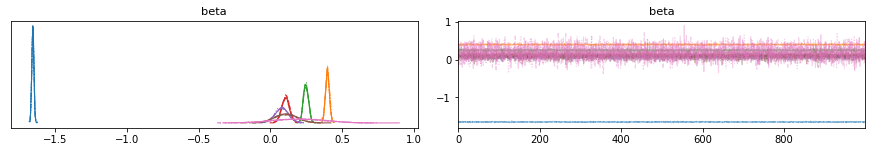

In [12]:
with pm.Model() as model_1:
    beta = pm.Normal('beta', mu=-5, sigma=10, shape=max_cap)
    p = sum(beta[i] * xhat[:, i] for i in range(max_cap))
    p = pm.math.invlogit(p)
    conversion = pm.Binomial('conversion', 
                             df_frequency_cap.users, 
                             p, 
                             observed=df_frequency_cap.conversions)
    model_1 = pm.sample(1000, tune=1000, chains=4, cores=4)
    pm.traceplot(model_1)

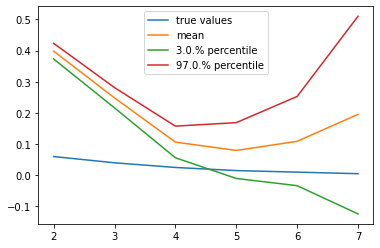

In [13]:
beta_plot_1 = np.array(model_1['beta']).T
plot_posteriors(df_frequency_cap.index[1:], beta_plot_1[1:], effects[1:])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


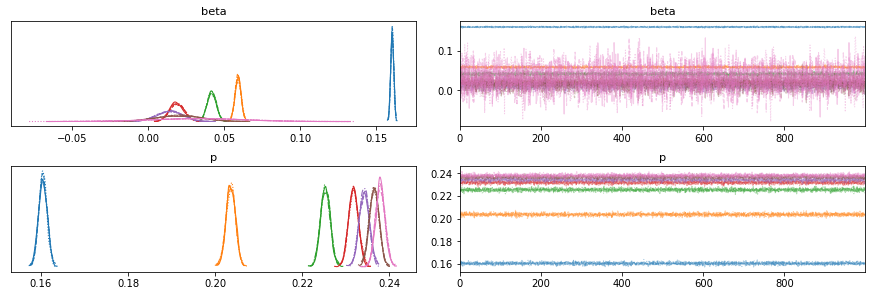

In [14]:
with pm.Model() as model_2:
    beta = pm.Normal('beta', mu=0, sigma=0.1, shape=max_cap)
    p = sum(beta[i] * xhat[:, i] for i in range(max_cap))
    p = pm.Deterministic('p', p)
    p_sample_average = df_frequency_cap.conversions / df_frequency_cap.users
    p_sigma = np.sqrt(df_frequency_cap.users * 
                      p_sample_average * (1 - p_sample_average))
    conversion = pm.Normal('conversion', 
                             mu = p * df_frequency_cap.users,
                             sigma = p_sigma, 
                             observed=df_frequency_cap.conversions)
    model_2 = pm.sample(1000, tune=1000, chains=4, cores=4)
    pm.traceplot(model_2)

0.1573034702740343 0.24191194184485362


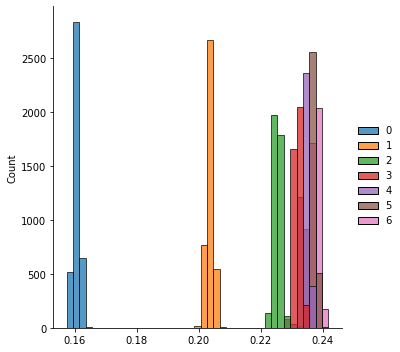

In [15]:
# are we ok with our normal distribution assumption?
print(np.min(model_2['p']), np.max(model_2['p']))
sns.displot(model_2['p'])

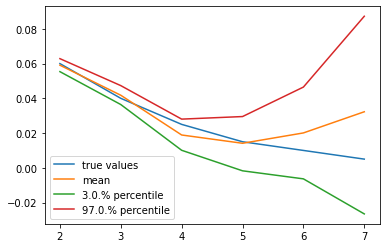

In [16]:
beta_plot_2 = np.array(model_2['beta']).T
plot_posteriors(df_frequency_cap.index[1:], beta_plot_2[1:], effects[1:])

## Making Assumptions
* Core of modelling: variance / bias trade-off

* Let's see what happens when we assume $\beta_i \geq 0$

In [ ]:
with pm.Model() as model_3:
    c = pm.Normal('c', mu = 0, sigma = 0.5)
    beta = pm.HalfNormal('beta', sigma=0.1, shape=max_cap)
    p = c + sum(beta[i] * xhat[:, i] for i in range(1, max_cap))
    # Note: we skip beta_0 because we now have c
    p = pm.Deterministic('p', p)
    p_sample_average = df_frequency_cap.conversions / df_frequency_cap.users
    p_sigma = np.sqrt(df_frequency_cap.users * 
                      p_sample_average * (1 - p_sample_average))
    conversion = pm.Normal('conversion', 
                             mu = p * df_frequency_cap.users,
                             sigma = p_sigma, 
                             observed=df_frequency_cap.conversions)
    model_3 = pm.sample(1000, tune=1000, chains=4, cores=4)
    pm.traceplot(model_3)

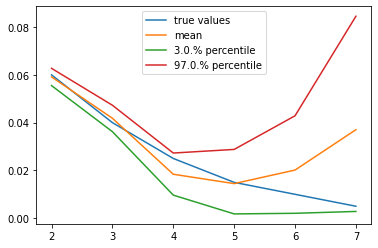

In [18]:
beta_plot_3 = np.array(model_3['beta']).T
plot_posteriors(df_frequency_cap.index[1:], beta_plot_3[1:], effects[1:])

## Making Assumptions
* Core of modelling: variance / bias trade-off

* Let's make some assumptions on a parametric for for $\beta_i$

## Define our model

<h1><center>
    $Y \sim $Binomial$(U, P(Y|Z)$<br>
    $P(Y|Z) = \alpha + $logistic$(c + \theta Z)$<br>
    $\alpha \sim $HalfNormal$(0.25)$<br>
    $c \sim $Normal$(0, 3)$<br>
    $\theta \sim $HalfNormal$(0.5)$<br>
</center></h1>

In [ ]:
with pm.Model() as model_4:
    c = pm.Normal('c', mu = 0, sigma = 0.5)
    alpha0 = pm.Normal('alpha0', mu=-2, sigma=2)
    alpha1 = pm.Normal('alpha1', mu=0, sigma=2)
    beta = pm.Deterministic('beta', 
                        np.exp(alpha0 + alpha1 * np.array(range(max_cap))))
    p = c + sum(beta[i] * xhat[:, i] for i in range(max_cap))
    p = pm.Deterministic('p', p)
    p_sample_average = df_frequency_cap.conversions / df_frequency_cap.users
    p_sigma = np.sqrt(df_frequency_cap.users * 
                      p_sample_average * (1 - p_sample_average))
    conversion = pm.Normal('conversion', 
                             mu = p * df_frequency_cap.users,
                             sigma = p_sigma, 
                             observed=df_frequency_cap.conversions)
    model_4 = pm.sample(1000, tune=1000, chains=4, cores=4)
    pm.traceplot(model_4)

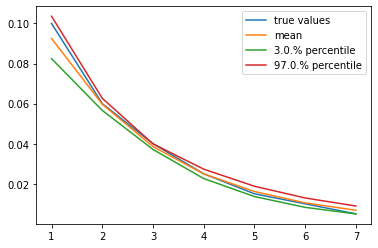

In [29]:
# Note: we also have an estimate for the first impressions now
beta_plot_4 = np.array(model_4['beta']).T
plot_posteriors(df_frequency_cap.index, beta_plot_4, effects)

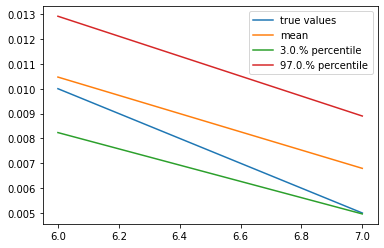

In [30]:
plot_posteriors(df_frequency_cap.index[5:7], beta_plot_4[5:7], effects[5:7])

## Include hierarchy in our model

<h1><center>
    $Y \sim $Binomial$(U, P(Y|Z)$<br>
    $P(Y|Z) = \alpha + $logistic$(c_Z + \theta Z)$<br>
    $\alpha \sim $HalfNormal$(0.25)$<br>
    $c \sim $Normal$(0, 3)$<br>
    $\sigma_c \sim $HalfNormal$(0, 0.2)$<br>
    $c_Z \sim $Normal$(c, \sigma_c)$<br>
    $\theta \sim $HalfNormal$(0.5)$<br>
</center></h1>

In [ ]:
with pm.Model() as model_5:
    alpha0_prior = pm.Normal('alpha0_prior', mu=-2, sigma=2)
    alpha0_sigma = pm.HalfNormal('alpha0_sigma', sigma = 0.5)
    alpha0 = pm.Normal('alpha0', 
                       mu=alpha0_prior, sigma=alpha0_sigma, shape=max_cap)
    alpha1 = pm.Normal('alpha1', mu=0, sigma=2)
    beta = pm.Deterministic('beta', 
                            np.exp(alpha0 + alpha1 * np.array(range(max_cap))))
    p = sum(beta[i] * xhat[:, i] for i in range(max_cap))
    p = pm.Deterministic('p', p)
    p_sample_average = df_frequency_cap.conversions / df_frequency_cap.users
    p_sigma = np.sqrt(df_frequency_cap.users * 
                      p_sample_average * (1 - p_sample_average))
    conversion = pm.Normal('conversion', 
                             mu = p * df_frequency_cap.users,
                             sigma = p_sigma, 
                             observed=df_frequency_cap.conversions)
    model_5 = pm.sample(1000, tune=1000, chains=4, cores=4)
    pm.traceplot(model_5)

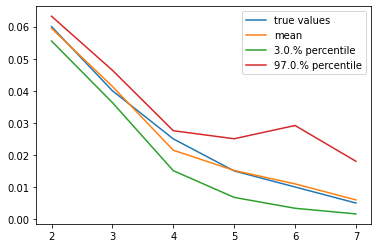

In [32]:
beta_plot_5 = np.array(model_5['beta']).T
plot_posteriors(df_frequency_cap.index[1:], beta_plot_5[1:], effects[1:])

## However...
* Our posteriors are too optimistic

* We assume $\hat{x}$ to be deterministic, while in fact $\hat{x} \sim Beta(a, b)$

* Estimation error (variance) within our estimates is in fact larger because of estimation error in the first stage

## What didn't work for me
* Implement theano random stream to do random draws from $\hat{x} \sim Beta(a, b)$ during MCMC estimation

* Estimation of $\hat{x}$ in the same model (i.e. estimate both stages at once)

In [ ]:
# Trying to estimate both stages at once like this, doesn't seem to work
with pm.Model() as model_6:
    xhat_pm = pm.Beta('xhat_pm', 1, 1, shape=(max_impr, max_cap))
    xbar = pm.Binomial('xbar', n_xhat, xhat_pm, observed=a_xhat)
    c = pm.Normal('c', mu = 0, sigma = 0.5)
    alpha0 = pm.Normal('alpha0', mu=-2, sigma=2)
    alpha1 = pm.Normal('alpha1', mu=0, sigma=2)
    beta = pm.Deterministic('beta', 
                            np.exp(alpha0 + alpha1 * np.array(range(max_cap))))
    p = c + sum(beta[i] * xhat_pm[:, i] for i in range(max_cap))
    p = pm.Deterministic('p', p)
    p_sample_average = df_frequency_cap.conversions / df_frequency_cap.users
    p_sigma = np.sqrt(df_frequency_cap.users * 
                      p_sample_average * (1 - p_sample_average))
    conversion = pm.Normal('conversion', 
                             mu = p * df_frequency_cap.users,
                             sigma = p_sigma, 
                             observed=df_frequency_cap.conversions)
    model_6 = pm.sample(1000, tune=1000, chains=4, cores=4)
    pm.traceplot(model_6)

## My 'bootstrapping' approach
* We sample from $\hat{x} \sim Beta(a, b)$ and estimate our model N times using the sampled $\tilde{x}$

In [ ]:
N_runs = 100

for r in range(N_runs):
    xtilde = stats.beta.rvs(a_xhat+1, b_xhat+1)
    print('This is run {} out of {}'.format(r+1, N_runs))
    try:
        with pm.Model() as model_7:
            c = pm.Normal('c', mu = 0, sigma = 0.5)
            alpha0 = pm.Normal('alpha0', mu=-2, sigma=2)
            alpha1 = pm.Normal('alpha1', mu=0, sigma=2)
            beta = pm.Deterministic('beta', 
                            np.exp(alpha0 + alpha1 * np.array(range(max_cap))))
            p = c + sum(beta[i] * xtilde[:, i] for i in range(max_cap))
            p = pm.Deterministic('p', p)
            p_sample_average = df_frequency_cap.conversions \
                                    / df_frequency_cap.users
            p_sigma = np.sqrt(df_frequency_cap.users * 
                              p_sample_average * (1 - p_sample_average))
            conversion = pm.Normal('conversion', 
                                     mu = p * df_frequency_cap.users,
                                     sigma = p_sigma, 
                                     observed=df_frequency_cap.conversions)
            model_7 = pm.sample(100, tune=1000, chains=4, cores=4)
    except:
        continue
    if r == 0:
        beta_plot_7 = np.array(model_7['beta'])
    else:
        beta_plot_7 = np.vstack((beta_plot_7, np.array(model_7['beta'])))

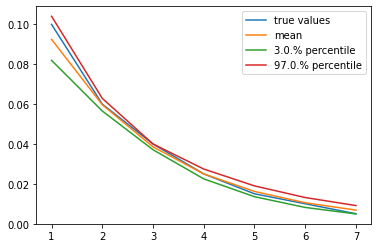

In [73]:
plot_posteriors(df_frequency_cap.index, beta_plot_7.T, effects)

In [74]:
N_runs = 100

for r in range(N_runs):
    xtilde = stats.beta.rvs(a_xhat+1, b_xhat+1)
    print(xtilde)
    print('This is run {} out of {}'.format(r+1, N_runs))
    try:
        with pm.Model() as model_8:
            beta = pm.Normal('beta', mu=0, sigma=0.1, shape=max_cap)
            p = sum(beta[i] * xtilde[:, i] for i in range(max_cap))
            p = pm.Deterministic('p', p)
            p_sample_average = df_frequency_cap.conversions / df_frequency_cap.users
            p_sigma = np.sqrt(df_frequency_cap.users * 
                              p_sample_average * (1 - p_sample_average))
            conversion = pm.Normal('conversion', 
                                     mu = p * df_frequency_cap.users,
                                     sigma = p_sigma, 
                                     observed=df_frequency_cap.conversions)
            model_8 = pm.sample(100, tune=1000, chains=4, cores=4)
    except:
        continue
    if r == 0:
        beta_plot_8 = np.array(model_8['beta'])
    else:
        beta_plot_8 = np.vstack((beta_plot_8, np.array(model_8['beta'])))

[[9.99970218e-01 2.86423999e-05 1.98102783e-06 6.09177259e-06
  1.59947572e-06 7.14031234e-07 9.86607699e-06]
 [9.99999444e-01 7.31199140e-01 6.13392763e-06 1.34333717e-06
  3.99736399e-05 1.39684641e-06 1.22604584e-05]
 [9.99993543e-01 7.27814470e-01 5.18935622e-01 3.62440622e-06
  1.02308968e-06 1.18798170e-06 8.07067027e-06]
 [9.99999927e-01 7.33646446e-01 5.21557161e-01 3.32500676e-01
  3.80870025e-07 3.45937074e-06 2.73513281e-06]
 [9.99999826e-01 7.26422845e-01 5.20748682e-01 3.28855770e-01
  1.90513315e-01 5.63380690e-06 1.30261074e-07]
 [9.99990198e-01 7.31436176e-01 5.19286673e-01 3.30635937e-01
  1.89888725e-01 1.10625294e-01 1.02355098e-05]
 [9.99998325e-01 7.26481321e-01 5.18759917e-01 3.31033967e-01
  1.88640226e-01 1.08526363e-01 5.02787884e-02]]
This is run 1 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 13 seconds.


[[9.99999653e-01 4.87480592e-06 1.25727552e-06 3.25846385e-06
  2.29031931e-06 1.64834767e-06 2.34176343e-06]
 [9.99992456e-01 7.29972833e-01 3.99674556e-06 1.43064502e-05
  1.77396691e-06 2.35560334e-05 4.84516001e-07]
 [9.99977144e-01 7.30107424e-01 5.21097413e-01 4.61290490e-06
  2.58930482e-05 6.69689636e-06 6.79188422e-06]
 [9.99991144e-01 7.33935382e-01 5.19988425e-01 3.32578908e-01
  7.86687207e-06 9.83372059e-07 6.88879601e-07]
 [9.99994093e-01 7.27362566e-01 5.19466011e-01 3.30190502e-01
  1.91215341e-01 9.29621054e-06 8.67820943e-07]
 [9.99989730e-01 7.31621526e-01 5.18071919e-01 3.31127576e-01
  1.88615052e-01 1.08567600e-01 1.71482178e-06]
 [9.99998377e-01 7.28549324e-01 5.18304123e-01 3.30722622e-01
  1.89204454e-01 1.08892248e-01 5.00039758e-02]]
This is run 2 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 12 seconds.


[[9.99986361e-01 8.61487173e-06 3.60057056e-06 1.84000758e-05
  4.14287301e-07 5.01450879e-06 7.88149271e-06]
 [9.99996003e-01 7.30156747e-01 2.70821933e-06 8.93101688e-06
  1.55362487e-05 2.53849168e-06 1.11281226e-05]
 [9.99995499e-01 7.28797907e-01 5.20132647e-01 3.02480354e-06
  1.79499204e-05 2.43105372e-06 2.83616771e-06]
 [9.99997930e-01 7.34368959e-01 5.20438220e-01 3.32142999e-01
  7.00947585e-06 2.61150203e-06 4.50069374e-06]
 [9.99994386e-01 7.29258607e-01 5.20277514e-01 3.30297105e-01
  1.90394642e-01 7.08486890e-06 1.46929344e-06]
 [9.99999098e-01 7.29921728e-01 5.21336954e-01 3.33343382e-01
  1.90862543e-01 1.10016230e-01 5.60207720e-06]
 [9.99992408e-01 7.27758268e-01 5.21364480e-01 3.30053007e-01
  1.91667786e-01 1.09816038e-01 4.93344071e-02]]
This is run 3 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 14 seconds.


[[9.99982577e-01 7.99560457e-06 7.72939561e-06 4.00383048e-06
  4.47412864e-07 1.04766652e-07 3.50303371e-06]
 [9.99995307e-01 7.29838081e-01 3.35392964e-06 1.91624271e-05
  6.79075418e-06 4.81189120e-06 5.19449273e-07]
 [9.99999045e-01 7.30632107e-01 5.19795706e-01 1.91142441e-05
  2.56072018e-06 7.65700215e-06 1.20312041e-06]
 [9.99994451e-01 7.32624252e-01 5.24811411e-01 3.31450607e-01
  7.57281421e-06 3.09365064e-06 2.69315242e-06]
 [9.99998891e-01 7.28007520e-01 5.22300641e-01 3.30573016e-01
  1.90053740e-01 6.20153469e-06 6.28750316e-07]
 [9.99994583e-01 7.30128021e-01 5.21122174e-01 3.32180154e-01
  1.88257946e-01 1.09319241e-01 1.79724622e-06]
 [9.99996424e-01 7.29961210e-01 5.18267872e-01 3.30287861e-01
  1.90162257e-01 1.09846728e-01 4.94313905e-02]]
This is run 4 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 15 seconds.


[[9.99991982e-01 6.03140962e-06 2.37089938e-06 9.54809170e-06
  8.45000508e-06 6.90077073e-06 5.15751977e-06]
 [9.99985331e-01 7.30252621e-01 3.53104501e-08 1.14308057e-05
  1.33759360e-06 7.13195328e-06 5.89113140e-07]
 [9.99994300e-01 7.28280549e-01 5.18450311e-01 6.01036730e-06
  6.02525875e-07 1.44058655e-06 2.78814853e-06]
 [9.99993199e-01 7.30154960e-01 5.25383353e-01 3.30932732e-01
  1.55411820e-05 2.15705171e-05 3.31173503e-06]
 [9.99986323e-01 7.31419072e-01 5.21284027e-01 3.29361586e-01
  1.90191991e-01 6.05546981e-06 1.75321059e-06]
 [9.99990907e-01 7.29378190e-01 5.21570915e-01 3.30039132e-01
  1.90974311e-01 1.11240941e-01 3.46369667e-06]
 [9.99995132e-01 7.27973777e-01 5.18653343e-01 3.30976249e-01
  1.89425522e-01 1.10093179e-01 5.07319461e-02]]
This is run 5 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 14 seconds.


[[9.99994741e-01 9.47902049e-06 1.90006943e-05 1.16807819e-05
  4.08493477e-06 1.87426796e-06 4.38043349e-06]
 [9.99998847e-01 7.28832893e-01 1.82680202e-06 4.13541610e-05
  3.44878946e-06 6.53133640e-06 1.54320797e-06]
 [9.99991553e-01 7.30217276e-01 5.21087699e-01 1.60361614e-05
  1.21285233e-05 5.52510123e-06 1.97004027e-06]
 [9.99988733e-01 7.31742178e-01 5.20582899e-01 3.32379945e-01
  1.76873924e-05 8.04986760e-07 2.07306723e-05]
 [9.99989856e-01 7.31392993e-01 5.21759643e-01 3.28905037e-01
  1.91256931e-01 2.13898120e-05 1.40917857e-05]
 [9.99996858e-01 7.30852667e-01 5.21878471e-01 3.29466199e-01
  1.89983265e-01 1.09205230e-01 1.51581570e-07]
 [9.99995294e-01 7.27803822e-01 5.17795064e-01 3.29940745e-01
  1.90987046e-01 1.08787236e-01 4.99852591e-02]]
This is run 6 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 13 seconds.


[[9.99997264e-01 2.94868752e-07 7.52575362e-07 9.84894525e-07
  1.16483977e-06 3.77293500e-07 5.01142640e-07]
 [9.99995044e-01 7.28062454e-01 7.24708573e-06 1.53984050e-05
  1.41382542e-06 1.60879358e-06 2.07528508e-05]
 [9.99994733e-01 7.31267105e-01 5.21329887e-01 5.25552010e-06
  3.99675932e-06 9.19203907e-06 5.38492252e-06]
 [9.99999255e-01 7.32634568e-01 5.23006536e-01 3.30764119e-01
  9.78499830e-06 9.88656394e-06 5.36477043e-06]
 [9.99962994e-01 7.28216834e-01 5.20659716e-01 3.27081418e-01
  1.90641184e-01 4.95808951e-06 2.17191615e-07]
 [9.99999069e-01 7.30447245e-01 5.19286089e-01 3.30829625e-01
  1.90498561e-01 1.09884861e-01 1.08874001e-05]
 [9.99999876e-01 7.28100177e-01 5.18329938e-01 3.29951837e-01
  1.90351253e-01 1.09852145e-01 5.09318366e-02]]
This is run 7 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 15 seconds.


[[9.99993003e-01 5.41143501e-07 2.05672455e-06 1.12400224e-06
  1.73615310e-05 5.87871440e-06 4.63116148e-06]
 [9.99971382e-01 7.31008857e-01 7.76460925e-06 4.41036767e-07
  2.17237078e-07 4.12267107e-06 1.88772242e-06]
 [9.99991780e-01 7.29100463e-01 5.19371089e-01 7.35718394e-06
  2.11192053e-07 3.73788415e-06 5.23296679e-07]
 [9.99992184e-01 7.32643878e-01 5.23367698e-01 3.31458848e-01
  1.23088326e-05 5.31238483e-06 9.69377753e-06]
 [9.99997638e-01 7.29456414e-01 5.20764667e-01 3.29962310e-01
  1.90109262e-01 2.34431208e-05 1.17473607e-06]
 [9.99997521e-01 7.31742167e-01 5.20858241e-01 3.30128125e-01
  1.88748415e-01 1.09275655e-01 1.80344306e-05]
 [9.99982383e-01 7.30810647e-01 5.20709620e-01 3.30359027e-01
  1.91184437e-01 1.08837263e-01 4.95832776e-02]]
This is run 8 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 13 seconds.


[[9.99997648e-01 4.01039781e-06 1.05133841e-05 5.22234803e-07
  2.61498637e-06 4.22900023e-05 3.49044180e-06]
 [9.99998238e-01 7.29044858e-01 3.48392547e-06 3.95412719e-07
  6.32574825e-06 7.55792944e-06 3.14982237e-05]
 [9.99999238e-01 7.31288502e-01 5.20331098e-01 3.06237033e-06
  7.26484292e-06 3.97024733e-06 3.07024485e-06]
 [9.99997608e-01 7.31546055e-01 5.22900276e-01 3.32463536e-01
  4.98259454e-07 9.47477624e-06 3.24627937e-05]
 [9.99997460e-01 7.29076055e-01 5.21438857e-01 3.27505114e-01
  1.89421722e-01 6.96158390e-06 9.58263509e-06]
 [9.99974384e-01 7.31305421e-01 5.20916170e-01 3.30664815e-01
  1.90622542e-01 1.10353243e-01 1.64938417e-05]
 [9.99978573e-01 7.28361961e-01 5.19943762e-01 3.32008763e-01
  1.89034048e-01 1.09917917e-01 5.07092381e-02]]
This is run 9 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 13 seconds.


[[9.99999087e-01 1.51603673e-05 1.58649978e-06 2.44866819e-05
  6.24646131e-07 1.80501048e-05 2.69800601e-07]
 [9.99994005e-01 7.28439934e-01 1.93765351e-05 1.52942555e-06
  8.93396850e-06 3.32604355e-06 1.85980102e-06]
 [9.99991373e-01 7.29408817e-01 5.19360606e-01 1.40418026e-06
  2.94444443e-06 8.68958822e-06 1.54484632e-05]
 [9.99974724e-01 7.32662384e-01 5.22079976e-01 3.29984037e-01
  9.42359235e-06 4.04132724e-06 1.58363144e-06]
 [9.99993954e-01 7.27989022e-01 5.19849445e-01 3.30396484e-01
  1.89960549e-01 1.06831831e-05 6.58822544e-07]
 [9.99983800e-01 7.32103305e-01 5.21834734e-01 3.28652015e-01
  1.91653565e-01 1.10409623e-01 5.14111626e-06]
 [9.99992091e-01 7.28993530e-01 5.16292952e-01 3.31407158e-01
  1.88976660e-01 1.10913424e-01 5.06746900e-02]]
This is run 10 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 13 seconds.


[[9.99993783e-01 3.35972467e-07 9.45187685e-07 4.80570407e-06
  9.21288556e-06 6.35947566e-06 1.02758074e-05]
 [9.99986766e-01 7.29395677e-01 1.75327992e-06 4.15246209e-07
  8.80491960e-07 2.70276714e-05 1.09282919e-05]
 [9.99974235e-01 7.31650402e-01 5.20940135e-01 1.59393195e-05
  4.23304873e-06 7.27395098e-06 7.44880962e-06]
 [9.99997525e-01 7.31156688e-01 5.23118557e-01 3.32990994e-01
  5.53606702e-06 5.09415877e-06 1.00822466e-05]
 [9.99991363e-01 7.30516779e-01 5.20121572e-01 3.29697980e-01
  1.88019022e-01 8.44492835e-06 2.03866067e-06]
 [9.99992117e-01 7.30966603e-01 5.19622033e-01 3.28827261e-01
  1.91446601e-01 1.09030952e-01 3.10210642e-06]
 [9.99999598e-01 7.28802287e-01 5.20299216e-01 3.31877133e-01
  1.89902064e-01 1.10156387e-01 5.00249126e-02]]
This is run 11 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 13 seconds.


[[9.99991639e-01 7.31772549e-06 9.25160182e-07 2.22809528e-06
  1.56650981e-05 1.49440701e-05 6.16504663e-06]
 [9.99999110e-01 7.28357910e-01 2.48929418e-06 3.88541422e-06
  6.73945534e-06 1.03009798e-06 9.07429609e-06]
 [9.99992988e-01 7.30282363e-01 5.20035958e-01 1.66027448e-06
  7.58270003e-06 3.38690010e-05 1.50083101e-06]
 [9.99987760e-01 7.33687222e-01 5.22773766e-01 3.29209362e-01
  5.63634308e-05 6.38412850e-06 7.83121153e-07]
 [9.99984418e-01 7.29423290e-01 5.19625579e-01 3.30626422e-01
  1.89560244e-01 9.37162263e-06 4.08592958e-06]
 [9.99999608e-01 7.33559828e-01 5.18420088e-01 3.30181824e-01
  1.89096316e-01 1.09061542e-01 4.17689997e-07]
 [9.99995042e-01 7.26602373e-01 5.16573683e-01 3.30910592e-01
  1.89264468e-01 1.07999829e-01 4.95955780e-02]]
This is run 12 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 13 seconds.
The acceptance probability does not match the target. It is 0.8805185633624801, but should be close to 0.8. Try to increase the number of tuning steps.


[[9.99987856e-01 1.05467222e-05 1.67771436e-06 9.39597809e-07
  6.50567986e-06 2.01497773e-06 1.22644255e-06]
 [9.99991898e-01 7.30848738e-01 3.55144690e-06 5.34207565e-07
  8.94002076e-07 5.16076493e-06 1.74375303e-05]
 [9.99996121e-01 7.29184536e-01 5.20992401e-01 4.81270111e-06
  4.53986045e-06 1.63508030e-05 1.87069428e-05]
 [9.99986531e-01 7.29122959e-01 5.21103247e-01 3.34301944e-01
  2.91790392e-06 7.93664653e-08 3.90389095e-06]
 [9.99996707e-01 7.29630166e-01 5.20093373e-01 3.28714994e-01
  1.90926941e-01 1.15783658e-05 6.19840265e-06]
 [9.99994487e-01 7.29995038e-01 5.22537414e-01 3.32131234e-01
  1.89430645e-01 1.11091625e-01 1.36661362e-06]
 [9.99999682e-01 7.28981868e-01 5.16953781e-01 3.29652950e-01
  1.90810027e-01 1.10934489e-01 5.02013081e-02]]
This is run 13 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 12 seconds.
The number of effective samples is smaller than 25% for some parameters.


[[9.99984190e-01 6.64731059e-06 6.17566561e-06 4.44680910e-06
  9.85777799e-06 4.26615365e-06 1.08199483e-05]
 [9.99995299e-01 7.28256197e-01 1.00312063e-06 5.36146830e-07
  8.49603045e-07 4.45745959e-06 4.29944005e-06]
 [9.99999488e-01 7.28181011e-01 5.20429989e-01 9.46380872e-06
  1.83130948e-06 2.26935655e-06 1.27599356e-05]
 [9.99982081e-01 7.32486942e-01 5.24442136e-01 3.30656560e-01
  2.79926492e-06 9.93322223e-06 9.49451553e-06]
 [9.99963505e-01 7.29647619e-01 5.21801598e-01 3.31023471e-01
  1.88799938e-01 2.08920984e-06 2.80692080e-06]
 [9.99998415e-01 7.32249932e-01 5.21814705e-01 3.32847613e-01
  1.90964942e-01 1.10152454e-01 8.71656679e-07]
 [9.99983887e-01 7.27793116e-01 5.18126968e-01 3.32231049e-01
  1.89472538e-01 1.10206513e-01 5.02567148e-02]]
This is run 14 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 13 seconds.


[[9.99999488e-01 5.07290684e-06 2.31964516e-05 4.97793815e-06
  1.32437185e-05 3.97757106e-06 3.31312169e-05]
 [9.99999865e-01 7.28365020e-01 7.35796029e-06 1.42661934e-06
  1.51504046e-05 9.16307573e-06 1.10862482e-06]
 [9.99993484e-01 7.29855929e-01 5.18722682e-01 8.39455419e-06
  7.08584803e-06 3.78996174e-06 1.29680620e-05]
 [9.99993255e-01 7.31283972e-01 5.24065017e-01 3.30985865e-01
  2.03591935e-06 1.28035618e-05 5.42437772e-06]
 [9.99995816e-01 7.31473998e-01 5.19035782e-01 3.28558137e-01
  1.91296546e-01 7.47296536e-06 1.20711121e-07]
 [9.99998238e-01 7.30136008e-01 5.19843134e-01 3.32991227e-01
  1.90308793e-01 1.09108900e-01 7.18977735e-06]
 [9.99999354e-01 7.29200562e-01 5.18490319e-01 3.30434933e-01
  1.89045922e-01 1.10243538e-01 4.98303649e-02]]
This is run 15 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 13 seconds.


[[9.99996544e-01 9.43816893e-06 2.64225222e-07 8.27109390e-07
  1.47974826e-06 1.64633866e-05 2.72786741e-06]
 [9.99990373e-01 7.29271847e-01 7.04252304e-06 1.19302746e-06
  3.06513469e-06 2.58150004e-06 1.72425316e-05]
 [9.99999197e-01 7.29352564e-01 5.20546482e-01 1.50616720e-06
  4.01739436e-06 4.63150197e-06 1.72637968e-05]
 [9.99993945e-01 7.30861501e-01 5.22226256e-01 3.30664424e-01
  9.97751801e-06 8.90931949e-06 5.18461080e-06]
 [9.99999502e-01 7.30237741e-01 5.19062684e-01 3.30425888e-01
  1.88759804e-01 1.58061046e-05 1.76568325e-06]
 [9.99990338e-01 7.30380912e-01 5.20078020e-01 3.32922467e-01
  1.90018998e-01 1.09418228e-01 3.26275497e-05]
 [9.99992332e-01 7.31552770e-01 5.18461574e-01 3.29523780e-01
  1.90679538e-01 1.10140632e-01 5.08632377e-02]]
This is run 16 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 13 seconds.


[[9.99996945e-01 2.45310179e-06 1.25444655e-06 1.66211245e-05
  8.66824901e-06 4.89948856e-07 1.42847672e-05]
 [9.99997938e-01 7.29953639e-01 8.35418861e-06 2.41070121e-06
  1.95113499e-06 1.14630707e-06 5.90587340e-07]
 [9.99997194e-01 7.30670006e-01 5.20251938e-01 4.21963895e-05
  9.42254447e-06 1.31230765e-05 4.46766357e-06]
 [9.99992929e-01 7.32646810e-01 5.19901307e-01 3.31103481e-01
  2.12749900e-05 1.08397047e-05 5.35657076e-07]
 [9.99985604e-01 7.31347238e-01 5.22573078e-01 3.29077121e-01
  1.89517432e-01 1.35854196e-05 1.90530730e-06]
 [9.99991524e-01 7.32556868e-01 5.20515517e-01 3.31203573e-01
  1.88179894e-01 1.10358890e-01 3.90747385e-06]
 [9.99997746e-01 7.27649650e-01 5.17387817e-01 3.30989381e-01
  1.89641291e-01 1.10969256e-01 5.07064301e-02]]
This is run 17 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 15 seconds.


[[9.99992645e-01 2.68808348e-06 2.51053163e-06 1.71735619e-06
  1.19037846e-06 2.38793944e-06 4.45319888e-06]
 [9.99994785e-01 7.30164656e-01 3.40706180e-06 5.43634004e-06
  1.37723316e-06 2.61905840e-06 6.24445565e-06]
 [9.99999268e-01 7.29428539e-01 5.20216191e-01 5.11428681e-06
  1.41128950e-05 9.66306434e-06 6.90558871e-07]
 [9.99994166e-01 7.29940850e-01 5.20619843e-01 3.33027124e-01
  2.48785903e-06 2.50152671e-05 1.25277765e-05]
 [9.99998024e-01 7.31248302e-01 5.20822727e-01 3.29606593e-01
  1.90606897e-01 6.50392382e-06 8.30434288e-06]
 [9.99995779e-01 7.30364313e-01 5.18896064e-01 3.32029870e-01
  1.88298859e-01 1.09498128e-01 7.62480196e-06]
 [9.99997749e-01 7.30314302e-01 5.20364607e-01 3.31939550e-01
  1.91418462e-01 1.08284861e-01 5.01569810e-02]]
This is run 18 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 13 seconds.


[[9.99988668e-01 3.00510860e-06 1.71538549e-06 6.52367279e-06
  3.65887374e-06 3.60944181e-06 1.08071431e-05]
 [9.99983724e-01 7.30337065e-01 1.07759665e-05 1.31545797e-07
  2.87514019e-06 7.88813389e-07 3.58812810e-06]
 [9.99995294e-01 7.31701294e-01 5.20420705e-01 3.28216871e-06
  4.09996532e-06 2.91277151e-06 1.01705110e-06]
 [9.99994565e-01 7.29976430e-01 5.21143390e-01 3.32770119e-01
  2.50836252e-06 2.95863601e-06 1.54061837e-06]
 [9.99998005e-01 7.29604160e-01 5.18580725e-01 3.29777439e-01
  1.91026179e-01 2.88862593e-06 4.19125351e-06]
 [9.99999467e-01 7.30070961e-01 5.20531652e-01 3.31505554e-01
  1.89893013e-01 1.11615976e-01 4.28542939e-07]
 [9.99989638e-01 7.26288904e-01 5.20200787e-01 3.29750345e-01
  1.89119397e-01 1.09216161e-01 5.12802752e-02]]
This is run 19 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 13 seconds.


[[9.99998979e-01 1.47868707e-06 4.04469934e-06 1.82307351e-06
  5.16460803e-06 1.05568598e-05 1.85445597e-07]
 [9.99996506e-01 7.30004095e-01 1.16986871e-05 6.14377723e-06
  5.56435730e-06 1.85928802e-06 2.66831733e-06]
 [9.99979444e-01 7.29193775e-01 5.21677323e-01 8.14045115e-06
  7.28109852e-06 7.41499703e-07 1.13064881e-05]
 [9.99983409e-01 7.30508729e-01 5.23374102e-01 3.30003711e-01
  4.60039732e-05 6.48095450e-06 4.48144402e-06]
 [9.99991581e-01 7.29142387e-01 5.21755295e-01 3.28895349e-01
  1.91726794e-01 2.29792486e-06 3.50055111e-05]
 [9.99996775e-01 7.31145065e-01 5.20477832e-01 3.31648242e-01
  1.91030065e-01 1.09216629e-01 1.05635028e-06]
 [9.99999895e-01 7.28980707e-01 5.18267923e-01 3.28336038e-01
  1.90748672e-01 1.09155717e-01 5.09173724e-02]]
This is run 20 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 13 seconds.
The acceptance probability does not match the target. It is 0.8814270222857986, but should be close to 0.8. Try to increase the number of tuning steps.


[[9.99987982e-01 5.55437769e-06 3.45721214e-06 6.80458176e-07
  1.91588511e-07 2.41039251e-06 6.61975668e-06]
 [9.99994451e-01 7.31605400e-01 1.11583888e-06 1.02881665e-05
  7.62074244e-06 3.44613670e-06 8.83128374e-06]
 [9.99998730e-01 7.28855588e-01 5.19768664e-01 1.61462159e-06
  3.32642759e-05 6.02698824e-06 2.27709251e-08]
 [9.99999346e-01 7.30618331e-01 5.22410737e-01 3.30014170e-01
  3.08078059e-07 8.72082282e-06 2.83862136e-05]
 [9.99982609e-01 7.30499048e-01 5.20735646e-01 3.31365882e-01
  1.88159408e-01 8.73780780e-07 3.38044668e-05]
 [9.99997318e-01 7.29305310e-01 5.21918487e-01 3.31300611e-01
  1.90043518e-01 1.09959658e-01 1.40696142e-05]
 [9.99997008e-01 7.28970340e-01 5.19881315e-01 3.29599058e-01
  1.89293126e-01 1.09882168e-01 5.04130061e-02]]
This is run 21 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 13 seconds.


[[9.99991919e-01 2.56375681e-06 7.60720417e-06 5.19488850e-06
  1.14153968e-05 9.84826691e-06 4.87991639e-06]
 [9.99998603e-01 7.30321052e-01 2.92588985e-06 3.70613512e-06
  2.35892414e-06 6.88569010e-07 5.59828480e-06]
 [9.99998216e-01 7.29649044e-01 5.19914684e-01 5.66555163e-07
  3.76901258e-06 5.87419164e-08 7.03819844e-06]
 [9.99978950e-01 7.31537108e-01 5.22816371e-01 3.30773144e-01
  1.80825339e-06 4.71585744e-06 2.37857348e-05]
 [9.99996895e-01 7.29287720e-01 5.21717813e-01 3.29323102e-01
  1.92196429e-01 8.74955940e-06 2.47630614e-06]
 [9.99994971e-01 7.31087108e-01 5.20339429e-01 3.30507088e-01
  1.91408743e-01 1.09178623e-01 1.30312490e-05]
 [9.99984137e-01 7.26905613e-01 5.19371132e-01 3.31433163e-01
  1.90248236e-01 1.09370751e-01 5.05166196e-02]]
This is run 22 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 13 seconds.
The acceptance probability does not match the target. It is 0.8857034222098298, but should be close to 0.8. Try to increase the number of tuning steps.


[[9.99992048e-01 2.26728475e-06 4.62298613e-07 2.88401609e-06
  2.08109338e-06 2.24631303e-05 1.51440373e-05]
 [9.99976887e-01 7.28493039e-01 4.84407558e-06 2.22411190e-06
  2.50918235e-05 3.49108391e-06 1.59743812e-05]
 [9.99995113e-01 7.30644468e-01 5.20922052e-01 6.22783812e-06
  6.46060815e-06 5.79386953e-07 1.19295785e-05]
 [9.99997473e-01 7.30377806e-01 5.22387611e-01 3.30421190e-01
  2.84047790e-06 1.60163159e-05 9.73411183e-06]
 [9.99999143e-01 7.29147335e-01 5.19332866e-01 3.30024697e-01
  1.90501218e-01 4.31622816e-07 1.13255884e-05]
 [9.99999996e-01 7.31674137e-01 5.22523638e-01 3.30539030e-01
  1.91511991e-01 1.09803657e-01 1.58818889e-07]
 [9.99988513e-01 7.27853496e-01 5.17951874e-01 3.29693057e-01
  1.89936578e-01 1.09224467e-01 4.99870679e-02]]
This is run 23 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 13 seconds.


[[9.99997060e-01 5.87102288e-06 7.13980327e-06 5.53361807e-06
  9.97986045e-07 8.61032480e-06 1.79643095e-06]
 [9.99987201e-01 7.30586542e-01 1.11795207e-06 1.21477061e-06
  1.69111955e-05 2.34178986e-06 3.57467804e-06]
 [9.99994060e-01 7.30244618e-01 5.20525445e-01 1.95981710e-06
  8.73284454e-06 1.84575633e-06 4.39220312e-06]
 [9.99994417e-01 7.31179078e-01 5.21675856e-01 3.31052778e-01
  3.97471131e-07 2.37536516e-05 4.73575282e-06]
 [9.99992229e-01 7.31994093e-01 5.21695343e-01 3.29676064e-01
  1.91295688e-01 2.24543743e-05 6.20100802e-06]
 [9.99999669e-01 7.31616662e-01 5.20247138e-01 3.31969032e-01
  1.89889510e-01 1.11074230e-01 3.03325396e-05]
 [9.99982939e-01 7.28046035e-01 5.16450548e-01 3.29680460e-01
  1.90554713e-01 1.09494231e-01 5.03578335e-02]]
This is run 24 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 13 seconds.


[[9.99997477e-01 2.01533959e-06 8.53563068e-06 1.38215620e-05
  2.69942113e-05 1.07096432e-05 1.42453255e-05]
 [9.99998017e-01 7.28477792e-01 3.65979406e-06 7.58735638e-06
  9.15562373e-07 1.21602649e-08 1.33009934e-05]
 [9.99990452e-01 7.28122062e-01 5.21680417e-01 3.19036328e-06
  5.02628332e-06 9.00439704e-06 1.38310009e-06]
 [9.99999204e-01 7.30981401e-01 5.23322171e-01 3.31603334e-01
  1.33380512e-05 5.54655596e-06 6.14509943e-06]
 [9.99993470e-01 7.29546724e-01 5.19555765e-01 3.30544298e-01
  1.92210177e-01 2.20969745e-07 1.23761720e-05]
 [9.99995776e-01 7.29565775e-01 5.18900213e-01 3.32511703e-01
  1.89671721e-01 1.08400336e-01 3.95118335e-06]
 [9.99964714e-01 7.26826843e-01 5.17981419e-01 3.32447727e-01
  1.90809126e-01 1.09471977e-01 5.09414413e-02]]
This is run 25 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 14 seconds.


[[9.99992108e-01 3.05669849e-06 1.54781642e-05 9.78316061e-06
  2.25963930e-05 5.17575777e-06 1.28184828e-06]
 [9.99996691e-01 7.29691027e-01 2.32620894e-06 1.22746262e-05
  3.24529658e-06 1.69534154e-05 3.64719905e-06]
 [9.99995488e-01 7.31251323e-01 5.19809966e-01 2.62491487e-07
  1.07936987e-05 8.85081357e-06 1.41383504e-06]
 [9.99993046e-01 7.30885127e-01 5.22721014e-01 3.32025918e-01
  2.33932218e-05 1.37689793e-06 7.22267870e-06]
 [9.99998848e-01 7.30866207e-01 5.21658528e-01 3.28048842e-01
  1.88817492e-01 7.21398683e-06 1.01137073e-05]
 [9.99999826e-01 7.32064535e-01 5.22416407e-01 3.30439550e-01
  1.90445657e-01 1.08960420e-01 1.46328032e-05]
 [9.99999251e-01 7.26284968e-01 5.18931593e-01 3.32117113e-01
  1.90438673e-01 1.09036750e-01 4.99421717e-02]]
This is run 26 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 13 seconds.


[[9.99995820e-01 8.38007877e-06 1.58596274e-06 5.72785729e-07
  4.90377460e-06 5.41052245e-06 1.01905385e-05]
 [9.99994193e-01 7.27869946e-01 1.16227013e-06 5.56637765e-06
  1.38953472e-05 3.20836846e-05 2.41787155e-06]
 [9.99982628e-01 7.30038363e-01 5.19083995e-01 3.65222107e-06
  7.43262432e-06 1.14183111e-05 1.86941994e-06]
 [9.99993004e-01 7.31609058e-01 5.23898118e-01 3.33135509e-01
  6.05201351e-06 3.01410677e-05 4.22420467e-06]
 [9.99999169e-01 7.32126290e-01 5.15981855e-01 3.28901787e-01
  1.91611967e-01 2.54366002e-07 4.49520306e-06]
 [9.99994302e-01 7.31716187e-01 5.19626617e-01 3.29926664e-01
  1.89864515e-01 1.09710785e-01 3.82739040e-05]
 [9.99996728e-01 7.29207202e-01 5.19707236e-01 3.31368998e-01
  1.89450611e-01 1.09142003e-01 5.10165405e-02]]
This is run 27 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 13 seconds.


[[9.99981477e-01 3.52257788e-06 7.16734904e-07 1.44002160e-05
  1.61407747e-05 6.39802985e-07 3.04244807e-06]
 [9.99999119e-01 7.32785441e-01 7.79106556e-06 2.64752560e-06
  2.58204224e-05 7.76034175e-06 8.31215838e-06]
 [9.99997372e-01 7.29601653e-01 5.20153379e-01 7.67920652e-07
  1.90239694e-05 9.57899833e-07 6.70382632e-06]
 [9.99989928e-01 7.30007094e-01 5.21864651e-01 3.32982781e-01
  1.05639070e-05 7.05234980e-06 2.56734076e-05]
 [9.99974674e-01 7.30239268e-01 5.18764433e-01 3.30586024e-01
  1.90650819e-01 1.06996539e-05 1.64332878e-06]
 [9.99993263e-01 7.29905226e-01 5.23075734e-01 3.30273339e-01
  1.87856468e-01 1.09041437e-01 2.18909865e-05]
 [9.99999469e-01 7.28951964e-01 5.16745785e-01 3.31552373e-01
  1.89624657e-01 1.10931077e-01 5.05110493e-02]]
This is run 28 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 13 seconds.


[[9.99999343e-01 1.14206102e-05 7.03302031e-07 2.40036344e-05
  4.58434806e-06 1.79383451e-06 8.19253307e-06]
 [9.99999035e-01 7.30915597e-01 1.10710444e-06 5.82252257e-06
  5.72235789e-06 2.62636132e-05 6.58343098e-06]
 [9.99995828e-01 7.28878275e-01 5.20695090e-01 7.34471190e-07
  5.39187638e-06 6.44422286e-06 3.37669911e-06]
 [9.99998692e-01 7.30929182e-01 5.22699836e-01 3.30450981e-01
  2.68069801e-06 1.82129312e-05 6.93412073e-06]
 [9.99991094e-01 7.31371511e-01 5.19239848e-01 3.28119563e-01
  1.92443732e-01 3.32892371e-07 1.30725916e-05]
 [9.99998061e-01 7.30960376e-01 5.21185767e-01 3.32347031e-01
  1.90508659e-01 1.10567978e-01 1.55577484e-05]
 [9.99992272e-01 7.28863652e-01 5.19048527e-01 3.32103005e-01
  1.90559855e-01 1.09752104e-01 5.05641368e-02]]
This is run 29 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 13 seconds.


[[9.99990315e-01 4.32743727e-06 8.09625524e-06 5.73194003e-06
  7.08893455e-07 8.14943465e-07 3.61057178e-07]
 [9.99979259e-01 7.30293638e-01 3.04738452e-07 1.98277378e-05
  2.44627484e-06 4.74147006e-06 7.10729065e-08]
 [9.99992030e-01 7.28919729e-01 5.21361220e-01 2.64837261e-05
  8.72921073e-06 6.03235212e-06 9.08572204e-06]
 [9.99988694e-01 7.31261800e-01 5.23635149e-01 3.31288612e-01
  6.15097825e-06 2.57896215e-05 1.56054193e-05]
 [9.99970948e-01 7.30582412e-01 5.18823195e-01 3.31159867e-01
  1.88794837e-01 2.83434348e-06 1.00024592e-07]
 [9.99990837e-01 7.33632721e-01 5.20653189e-01 3.32047376e-01
  1.88686906e-01 1.09572622e-01 3.71871664e-06]
 [9.99999972e-01 7.28758850e-01 5.22228132e-01 3.31974136e-01
  1.88116789e-01 1.08983010e-01 5.04880152e-02]]
This is run 30 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 12 seconds.


[[9.99996918e-01 7.60636362e-08 2.47200202e-06 1.80994948e-05
  1.00339762e-05 3.46741860e-06 1.25070907e-05]
 [9.99995598e-01 7.29090086e-01 7.74003617e-06 8.08594136e-06
  4.27994941e-06 9.67673559e-06 2.66641210e-06]
 [9.99996548e-01 7.29088787e-01 5.20367043e-01 5.97687412e-06
  1.41884789e-05 3.67845806e-05 1.61029758e-05]
 [9.99996317e-01 7.32476473e-01 5.22424019e-01 3.31065999e-01
  6.60245576e-07 2.00167682e-06 6.69207539e-06]
 [9.99994528e-01 7.29496615e-01 5.18426925e-01 3.28624843e-01
  1.91821707e-01 1.27530661e-06 1.00233267e-05]
 [9.99985282e-01 7.29187595e-01 5.20059945e-01 3.32314147e-01
  1.90145729e-01 1.09403503e-01 6.90425576e-07]
 [9.99994515e-01 7.28598708e-01 5.16737758e-01 3.29463407e-01
  1.88300252e-01 1.09645196e-01 5.09285197e-02]]
This is run 31 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 13 seconds.
The acceptance probability does not match the target. It is 0.8849339072265084, but should be close to 0.8. Try to increase the number of tuning steps.


[[9.99997589e-01 8.07680719e-06 4.21619460e-06 3.15832215e-06
  1.94273396e-07 6.45711153e-06 5.24198576e-06]
 [9.99993125e-01 7.28287982e-01 1.61682651e-05 4.82288790e-06
  1.40903918e-07 6.95882073e-06 3.02561218e-06]
 [9.99990081e-01 7.29998018e-01 5.19338231e-01 1.36751590e-06
  1.10548267e-05 1.46263744e-07 3.06606237e-07]
 [9.99999807e-01 7.31042408e-01 5.24673267e-01 3.31387973e-01
  1.13937975e-05 5.86006882e-08 2.07599854e-05]
 [9.99986957e-01 7.30955987e-01 5.21115225e-01 3.29184181e-01
  1.92005897e-01 3.16948179e-06 1.93204477e-06]
 [9.99997381e-01 7.30413824e-01 5.19140425e-01 3.29003530e-01
  1.88614972e-01 1.09142713e-01 7.46665892e-06]
 [9.99995318e-01 7.28027860e-01 5.19634471e-01 3.30953421e-01
  1.90386860e-01 1.10100122e-01 5.13229867e-02]]
This is run 32 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 12 seconds.


[[9.99993556e-01 1.96274990e-06 3.73841745e-06 3.74133775e-06
  1.59173053e-06 1.11836572e-05 4.35335415e-06]
 [9.99991775e-01 7.29813436e-01 1.47599982e-06 1.34875105e-05
  4.49979118e-06 6.00256901e-07 9.21005623e-06]
 [9.99991058e-01 7.28436658e-01 5.20122381e-01 4.24163453e-07
  8.01036021e-06 8.72013815e-06 3.34545822e-06]
 [9.99991974e-01 7.30506623e-01 5.21388362e-01 3.30842341e-01
  1.69410798e-05 1.74645455e-05 1.41727065e-05]
 [9.99999139e-01 7.28160956e-01 5.19388699e-01 3.28886077e-01
  1.90173947e-01 1.76694961e-06 7.30936297e-06]
 [9.99984749e-01 7.29189901e-01 5.21942367e-01 3.29744931e-01
  1.90169797e-01 1.08586481e-01 1.05574064e-06]
 [9.99994887e-01 7.29820834e-01 5.21106764e-01 3.31191141e-01
  1.91165225e-01 1.10906905e-01 5.03192684e-02]]
This is run 33 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 12 seconds.


[[9.99999594e-01 3.21076612e-06 1.71305444e-05 6.86071499e-06
  2.33310345e-05 1.30174864e-07 3.86852891e-07]
 [9.99978521e-01 7.30942023e-01 9.75637578e-07 1.34232712e-06
  1.32757545e-06 5.54353299e-07 4.81928967e-06]
 [9.99993726e-01 7.28419722e-01 5.22408483e-01 5.98916668e-06
  3.99062882e-06 3.67974796e-06 1.91311302e-06]
 [9.99991732e-01 7.32047465e-01 5.23877503e-01 3.32047872e-01
  1.61990339e-05 1.06256257e-06 9.26069361e-06]
 [9.99974998e-01 7.28254814e-01 5.21463553e-01 3.30254184e-01
  1.91635945e-01 1.92166571e-06 4.73902759e-06]
 [9.99991733e-01 7.29359132e-01 5.21853125e-01 3.29894021e-01
  1.89663661e-01 1.09558571e-01 1.94237951e-06]
 [9.99999857e-01 7.29600142e-01 5.18462731e-01 3.33668930e-01
  1.89335480e-01 1.09891825e-01 5.03952987e-02]]
This is run 34 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 13 seconds.


[[9.99998940e-01 2.17284012e-08 3.88076838e-07 4.62392960e-06
  4.73610152e-08 4.04173499e-06 2.12243984e-05]
 [9.99998465e-01 7.29905831e-01 1.01246824e-05 1.63897015e-05
  1.59527462e-05 2.87167440e-06 5.50950346e-06]
 [9.99998831e-01 7.30391902e-01 5.23158443e-01 6.34443318e-06
  4.29357516e-06 1.72766493e-06 4.78266179e-06]
 [9.99998272e-01 7.32378912e-01 5.20706274e-01 3.32398563e-01
  9.23001789e-07 3.60952218e-06 6.57555038e-06]
 [9.99992753e-01 7.28769463e-01 5.22109718e-01 3.28860901e-01
  1.90199443e-01 9.63786326e-06 2.33612349e-06]
 [9.99984856e-01 7.32701616e-01 5.21009995e-01 3.32117520e-01
  1.91817636e-01 1.10758193e-01 6.01621182e-06]
 [9.99991663e-01 7.29580533e-01 5.17770413e-01 3.31010891e-01
  1.89062544e-01 1.08518542e-01 4.98048215e-02]]
This is run 35 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 13 seconds.


[[9.99992172e-01 5.02459559e-06 1.96865266e-05 1.19029131e-05
  1.00354808e-05 8.05634945e-06 2.41221511e-06]
 [9.99995335e-01 7.29828755e-01 9.04896914e-06 4.88875829e-06
  3.89807363e-06 1.70057379e-05 2.97356655e-06]
 [9.99993507e-01 7.27205471e-01 5.20803002e-01 2.32129734e-05
  8.82723563e-06 5.26895221e-06 2.74747706e-06]
 [9.99981676e-01 7.32208306e-01 5.21025609e-01 3.31694472e-01
  8.62329230e-06 1.50978615e-05 6.14690526e-06]
 [9.99993724e-01 7.30231416e-01 5.20703425e-01 3.30808242e-01
  1.91670921e-01 4.49769643e-07 2.92952431e-06]
 [9.99983856e-01 7.31079646e-01 5.21772451e-01 3.30733748e-01
  1.92107311e-01 1.11738859e-01 1.47513641e-05]
 [9.99996642e-01 7.28659240e-01 5.18700360e-01 3.31627612e-01
  1.89241583e-01 1.09833935e-01 5.02131340e-02]]
This is run 36 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 13 seconds.
The acceptance probability does not match the target. It is 0.8789847576931649, but should be close to 0.8. Try to increase the number of tuning steps.


[[9.99993763e-01 5.89147149e-06 3.81779029e-07 5.99239491e-06
  5.67479294e-06 5.07635637e-06 1.14535015e-06]
 [9.99989019e-01 7.29659865e-01 1.55053563e-05 1.58653890e-06
  5.81188904e-09 1.41711764e-05 1.07082967e-05]
 [9.99999512e-01 7.31107100e-01 5.18628743e-01 2.72423945e-06
  9.07683580e-06 8.80357106e-07 3.43084603e-07]
 [9.99978451e-01 7.33164665e-01 5.23535628e-01 3.31120500e-01
  6.72592358e-06 7.27088479e-06 9.05828331e-06]
 [9.99992993e-01 7.30607283e-01 5.21376015e-01 3.30036790e-01
  1.89700474e-01 7.73666806e-06 4.21712397e-07]
 [9.99992548e-01 7.29530039e-01 5.22286965e-01 3.31872856e-01
  1.90525163e-01 1.09181776e-01 9.38392432e-06]
 [9.99996248e-01 7.27756033e-01 5.19535504e-01 3.29930213e-01
  1.91511484e-01 1.10106137e-01 4.99947651e-02]]
This is run 37 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 13 seconds.


[[9.99999793e-01 1.79597775e-06 1.00775029e-06 2.45680504e-05
  1.60502046e-06 1.62331429e-06 4.68884226e-06]
 [9.99999144e-01 7.31014891e-01 1.78398742e-05 1.52466099e-06
  4.46181598e-06 7.78384159e-06 4.45922681e-06]
 [9.99992332e-01 7.28503754e-01 5.21450939e-01 1.99759363e-05
  1.24155532e-05 1.80458000e-06 5.95879678e-07]
 [9.99999661e-01 7.30258836e-01 5.21394519e-01 3.31541646e-01
  4.01346976e-06 1.33835345e-05 1.07842303e-05]
 [9.99991508e-01 7.30570556e-01 5.22722663e-01 3.29593501e-01
  1.89126358e-01 4.72165004e-06 8.69486706e-06]
 [9.99999991e-01 7.27834424e-01 5.19910707e-01 3.30610046e-01
  1.89702980e-01 1.10571348e-01 2.73650374e-06]
 [9.99997646e-01 7.26724347e-01 5.17047771e-01 3.31186056e-01
  1.89314802e-01 1.08684484e-01 5.01946068e-02]]
This is run 38 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 13 seconds.
The acceptance probability does not match the target. It is 0.8803526037199464, but should be close to 0.8. Try to increase the number of tuning steps.


[[9.99978891e-01 1.33361026e-05 1.60673639e-06 6.82853174e-07
  6.87382538e-06 8.75207811e-06 1.11082173e-05]
 [9.99999568e-01 7.30366612e-01 1.43765023e-05 6.53704570e-06
  6.04450007e-06 2.37240662e-05 1.14759828e-05]
 [9.99993568e-01 7.31708515e-01 5.19003036e-01 5.94750207e-06
  1.49528983e-06 9.11876962e-07 1.29479468e-05]
 [9.99998353e-01 7.31063655e-01 5.20440528e-01 3.30135624e-01
  1.00700204e-06 8.30439944e-06 2.03357311e-06]
 [9.99987605e-01 7.28932580e-01 5.20890823e-01 3.31148456e-01
  1.89179427e-01 1.55319302e-06 6.46815322e-07]
 [9.99992739e-01 7.31134545e-01 5.17092989e-01 3.30690183e-01
  1.90085570e-01 1.09921562e-01 9.49770081e-07]
 [9.99999619e-01 7.28443019e-01 5.19077110e-01 3.33173866e-01
  1.89588536e-01 1.09097192e-01 4.96699118e-02]]
This is run 39 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 13 seconds.


[[9.99981654e-01 2.42379029e-05 7.94853901e-06 2.67968874e-06
  8.12439984e-07 1.24615584e-05 2.28075914e-05]
 [9.99990245e-01 7.28072336e-01 1.46816005e-05 5.24142154e-06
  4.41472959e-07 1.18915005e-05 1.27383088e-06]
 [9.99997615e-01 7.30721559e-01 5.20321672e-01 8.04358177e-06
  1.24240364e-05 3.47763040e-06 4.82026309e-06]
 [9.99998229e-01 7.31563885e-01 5.20824929e-01 3.31522831e-01
  1.21407235e-05 1.34104327e-06 4.51559319e-06]
 [9.99961481e-01 7.29521204e-01 5.18734211e-01 3.29055871e-01
  1.92370530e-01 1.18013186e-05 1.09029785e-05]
 [9.99996843e-01 7.31786767e-01 5.18765869e-01 3.32399054e-01
  1.91379472e-01 1.10037056e-01 6.97182300e-06]
 [9.99971191e-01 7.28438752e-01 5.21528291e-01 3.31355320e-01
  1.89354388e-01 1.08769886e-01 4.94741863e-02]]
This is run 40 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 13 seconds.
The acceptance probability does not match the target. It is 0.888770911171466, but should be close to 0.8. Try to increase the number of tuning steps.


[[9.99990132e-01 1.75026180e-05 2.16232086e-05 2.34087252e-05
  4.01676165e-06 7.90688639e-06 4.44378726e-06]
 [9.99984357e-01 7.30769893e-01 1.62346901e-05 6.79397123e-07
  1.16057515e-05 3.29204056e-06 6.08232607e-06]
 [9.99998363e-01 7.30367415e-01 5.20599936e-01 2.05672421e-05
  1.29222359e-05 3.03036571e-06 4.03034181e-06]
 [9.99997702e-01 7.31075563e-01 5.22184607e-01 3.31566282e-01
  1.36174562e-05 2.87901601e-06 1.50309016e-05]
 [9.99983770e-01 7.29065611e-01 5.20291032e-01 3.27489718e-01
  1.90248920e-01 3.86779427e-06 4.65974836e-06]
 [9.99995917e-01 7.30853741e-01 5.22507005e-01 3.31589176e-01
  1.90753722e-01 1.08479294e-01 1.18082365e-06]
 [9.99988744e-01 7.28959640e-01 5.18214455e-01 3.32701888e-01
  1.88345082e-01 1.10834627e-01 5.02752255e-02]]
This is run 41 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 13 seconds.


[[9.99995708e-01 1.81593482e-05 1.70490354e-05 1.03504262e-05
  1.13837246e-05 3.38277667e-06 1.94377958e-05]
 [9.99998974e-01 7.29572390e-01 3.73001433e-05 8.43657928e-06
  1.25146304e-05 3.91864617e-06 1.02054015e-05]
 [9.99994894e-01 7.29365915e-01 5.21009656e-01 4.13339858e-06
  6.23701864e-06 2.41316947e-05 2.36191319e-06]
 [9.99998611e-01 7.30941568e-01 5.22335640e-01 3.33233641e-01
  3.24713771e-06 2.18081988e-05 5.51812998e-06]
 [9.99996804e-01 7.30300069e-01 5.24465880e-01 3.28791793e-01
  1.90480557e-01 1.99025125e-06 3.63783208e-06]
 [9.99996532e-01 7.32120886e-01 5.19849879e-01 3.31614127e-01
  1.89999188e-01 1.09524515e-01 1.77363935e-05]
 [9.99988909e-01 7.27609967e-01 5.19420521e-01 3.28213700e-01
  1.90384336e-01 1.09222480e-01 5.06725504e-02]]
This is run 42 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 13 seconds.


[[9.99996681e-01 8.52841617e-06 4.53281205e-06 2.12997072e-05
  4.32516558e-06 9.82362891e-06 1.31680682e-05]
 [9.99985170e-01 7.29504166e-01 9.92604072e-06 8.52324457e-07
  2.34653128e-07 1.33647603e-05 1.42622331e-06]
 [9.99988630e-01 7.31167359e-01 5.20829402e-01 2.34312294e-06
  1.87373696e-05 3.74892523e-06 1.10915804e-05]
 [9.99994760e-01 7.30823797e-01 5.21942134e-01 3.34427446e-01
  6.09547449e-07 3.78422905e-06 3.89380002e-07]
 [9.99999668e-01 7.29888577e-01 5.19505494e-01 3.31794030e-01
  1.91103786e-01 3.52786317e-07 4.58491264e-06]
 [9.99998424e-01 7.29808399e-01 5.20470401e-01 3.32482944e-01
  1.89814693e-01 1.09882702e-01 1.65041025e-05]
 [9.99981032e-01 7.28126984e-01 5.20622242e-01 3.32014163e-01
  1.88208022e-01 1.08733212e-01 5.03266621e-02]]
This is run 43 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 13 seconds.
The acceptance probability does not match the target. It is 0.8842634966518087, but should be close to 0.8. Try to increase the number of tuning steps.


[[9.99994123e-01 1.34467967e-05 1.07587053e-05 5.39794372e-06
  2.75366987e-06 3.43828535e-06 1.00450754e-05]
 [9.99997083e-01 7.30169748e-01 4.72697476e-07 1.24737411e-05
  3.63893004e-07 1.08259127e-06 2.10242134e-05]
 [9.99996180e-01 7.30210667e-01 5.22239404e-01 5.00718639e-06
  1.07149658e-06 4.37034277e-06 1.24351165e-06]
 [9.99996501e-01 7.33422841e-01 5.24628172e-01 3.33576516e-01
  6.53920091e-06 2.04003645e-06 8.32264627e-06]
 [9.99986840e-01 7.29054699e-01 5.19285344e-01 3.30544418e-01
  1.90045010e-01 6.67964351e-06 4.90915679e-07]
 [9.99996969e-01 7.30995101e-01 5.22013105e-01 3.31773224e-01
  1.89742024e-01 1.08961027e-01 1.45372391e-05]
 [9.99998487e-01 7.29954198e-01 5.18386768e-01 3.30953232e-01
  1.89629294e-01 1.08741808e-01 4.97799406e-02]]
This is run 44 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 13 seconds.


[[9.99997570e-01 6.73164842e-06 1.99961212e-06 8.99027990e-07
  1.30352901e-05 1.62925763e-06 1.06717243e-05]
 [9.99989669e-01 7.29394211e-01 5.97761237e-06 1.04158727e-06
  1.01040521e-06 3.96863423e-06 1.12948046e-06]
 [9.99996636e-01 7.30485081e-01 5.21340564e-01 1.81006777e-05
  7.95913554e-06 1.61005203e-05 2.14121969e-06]
 [9.99998981e-01 7.33497176e-01 5.22819513e-01 3.34303938e-01
  9.41609414e-06 2.40833988e-06 2.84222701e-06]
 [9.99998747e-01 7.29012163e-01 5.22120991e-01 3.28511389e-01
  1.90213270e-01 2.33786999e-05 1.40117917e-05]
 [9.99999321e-01 7.32900077e-01 5.20902646e-01 3.30973875e-01
  1.90052259e-01 1.09847674e-01 1.66562048e-05]
 [9.99999029e-01 7.27925224e-01 5.17878136e-01 3.29560872e-01
  1.88522072e-01 1.10016994e-01 4.98114274e-02]]
This is run 45 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 13 seconds.
The acceptance probability does not match the target. It is 0.8818131535463004, but should be close to 0.8. Try to increase the number of tuning steps.


[[9.99999678e-01 2.59669659e-06 3.53017355e-06 1.57079372e-06
  9.38153839e-07 1.27939307e-05 1.06143688e-05]
 [9.99992731e-01 7.31802301e-01 6.17542374e-08 1.55294526e-06
  9.83536935e-08 3.58385184e-06 5.82759278e-06]
 [9.99996844e-01 7.30711545e-01 5.20843675e-01 5.10144677e-07
  3.63996501e-06 1.24230370e-05 4.16218783e-06]
 [9.99995127e-01 7.31987775e-01 5.22497792e-01 3.31115794e-01
  1.39778895e-06 9.13370343e-06 2.64732803e-05]
 [9.99976727e-01 7.30770570e-01 5.19017722e-01 3.29820242e-01
  1.92150502e-01 6.91849116e-06 1.13293554e-05]
 [9.99997791e-01 7.28450028e-01 5.18727747e-01 3.31659010e-01
  1.91757735e-01 1.09175756e-01 1.07154261e-05]
 [9.99998227e-01 7.27227215e-01 5.16712755e-01 3.31084518e-01
  1.90660916e-01 1.11898058e-01 4.98068347e-02]]
This is run 46 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 12 seconds.


[[9.99957297e-01 6.00930637e-06 3.53504998e-06 2.62015966e-06
  6.72241834e-06 1.52258061e-06 5.84393413e-06]
 [9.99986589e-01 7.30929243e-01 3.58124358e-08 8.84260530e-07
  9.47346816e-06 1.86231665e-05 1.70280150e-06]
 [9.99994249e-01 7.30926500e-01 5.21510854e-01 1.00643616e-05
  2.66480385e-06 1.07345992e-05 7.12356016e-07]
 [9.99996892e-01 7.33058968e-01 5.23130622e-01 3.32839391e-01
  1.02128833e-05 4.21661184e-06 2.48513432e-05]
 [9.99997574e-01 7.29750310e-01 5.20246820e-01 3.30157996e-01
  1.89816755e-01 1.69092731e-07 7.08197202e-06]
 [9.99988334e-01 7.30430112e-01 5.19035742e-01 3.30365532e-01
  1.90902260e-01 1.09337624e-01 2.06149672e-05]
 [9.99997801e-01 7.28621220e-01 5.16322785e-01 3.31380320e-01
  1.89541738e-01 1.10404471e-01 4.97812163e-02]]
This is run 47 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 13 seconds.


[[9.99996174e-01 4.89668653e-06 1.24862639e-05 6.05019693e-06
  2.66702035e-06 1.86200684e-06 1.90251629e-05]
 [9.99998835e-01 7.28766874e-01 1.83918906e-06 1.79046368e-05
  1.72540904e-06 4.95875137e-06 1.70473793e-05]
 [9.99994418e-01 7.28387519e-01 5.20474012e-01 6.66958365e-07
  2.35746693e-06 4.61282349e-06 1.21908553e-05]
 [9.99998437e-01 7.31313374e-01 5.22421345e-01 3.32169307e-01
  4.78740173e-06 1.39997114e-05 2.57102488e-05]
 [9.99989516e-01 7.28089781e-01 5.22346839e-01 3.28321044e-01
  1.91663882e-01 7.25621189e-06 4.97963832e-06]
 [9.99996723e-01 7.31501455e-01 5.21442133e-01 3.30099061e-01
  1.88788645e-01 1.09700288e-01 6.52357670e-06]
 [9.99997693e-01 7.30238027e-01 5.17398531e-01 3.30257382e-01
  1.91142079e-01 1.09505429e-01 5.11074713e-02]]
This is run 48 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 13 seconds.


[[9.99999015e-01 4.00254247e-06 1.07336793e-06 6.56264071e-06
  9.46237027e-06 1.25262318e-05 6.17153948e-06]
 [9.99986393e-01 7.31337813e-01 4.49555748e-07 9.82697370e-06
  7.24877481e-06 8.79363243e-06 1.64174203e-06]
 [9.99988864e-01 7.29527633e-01 5.17849292e-01 5.90085164e-06
  7.75706079e-06 2.57408270e-07 1.31662230e-05]
 [9.99997053e-01 7.31838999e-01 5.21821170e-01 3.30271936e-01
  2.68278664e-05 6.06465884e-06 5.85059448e-06]
 [9.99975590e-01 7.30548001e-01 5.21133756e-01 3.32966863e-01
  1.91749076e-01 7.98442457e-06 2.90918144e-06]
 [9.99996473e-01 7.29755859e-01 5.19405480e-01 3.29987790e-01
  1.90205005e-01 1.10288015e-01 1.10347210e-05]
 [9.99998353e-01 7.29016979e-01 5.18902638e-01 3.32009726e-01
  1.93009945e-01 1.09646118e-01 5.03112496e-02]]
This is run 49 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 16 seconds.


[[9.99983165e-01 1.08244150e-06 1.48974809e-06 6.77080697e-06
  5.61443898e-06 4.81745611e-06 5.80554685e-06]
 [9.99999509e-01 7.30697447e-01 2.84123094e-06 2.30443499e-06
  2.53238082e-05 3.30840030e-07 3.76939504e-07]
 [9.99999647e-01 7.29704857e-01 5.20476928e-01 6.08663850e-07
  6.20512850e-06 2.75105737e-05 3.50668932e-07]
 [9.99999953e-01 7.31710989e-01 5.20408378e-01 3.31786864e-01
  6.52751547e-06 2.16507193e-05 1.30465854e-05]
 [9.99988250e-01 7.29291933e-01 5.21325556e-01 3.29439892e-01
  1.91983646e-01 9.00375435e-06 1.05616094e-05]
 [9.99999795e-01 7.28977485e-01 5.20382265e-01 3.31710567e-01
  1.90821423e-01 1.10446730e-01 1.08667376e-05]
 [9.99984755e-01 7.30289146e-01 5.17330181e-01 3.30951786e-01
  1.87475663e-01 1.09265968e-01 5.00316053e-02]]
This is run 50 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 17 seconds.


[[9.99999092e-01 1.97320322e-06 1.75533081e-05 1.63548602e-05
  3.15577920e-06 1.04562091e-05 1.14100251e-05]
 [9.99997793e-01 7.30011575e-01 3.36348665e-05 1.36440959e-05
  2.61631606e-07 1.19324641e-05 4.45035298e-06]
 [9.99992326e-01 7.29565588e-01 5.20299021e-01 4.63063442e-08
  8.23723342e-07 9.81993422e-06 1.09670186e-05]
 [9.99999523e-01 7.30021598e-01 5.21415683e-01 3.33377176e-01
  4.50032618e-06 1.74674181e-06 3.13088526e-06]
 [9.99991418e-01 7.29603373e-01 5.17499030e-01 3.29619477e-01
  1.89282762e-01 5.25067273e-06 1.84552902e-06]
 [9.99993937e-01 7.30863135e-01 5.22662626e-01 3.31025099e-01
  1.90992159e-01 1.09690899e-01 2.49694125e-06]
 [9.99997824e-01 7.26787423e-01 5.18759144e-01 3.30895617e-01
  1.91890125e-01 1.08852331e-01 5.04560981e-02]]
This is run 51 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 14 seconds.


[[9.99998170e-01 1.43853861e-05 1.06115127e-05 2.04749146e-06
  5.74506949e-06 3.44531001e-05 5.55229635e-06]
 [9.99997659e-01 7.29280471e-01 1.01661806e-05 6.42131378e-06
  1.49866080e-05 1.48288242e-06 1.64938676e-06]
 [9.99983904e-01 7.30348182e-01 5.21216947e-01 2.75616577e-06
  3.77712464e-06 4.46281472e-06 9.00831487e-07]
 [9.99994571e-01 7.30648042e-01 5.20428341e-01 3.31387039e-01
  1.38369127e-05 6.44699599e-07 5.89836618e-06]
 [9.99997534e-01 7.30145814e-01 5.20966716e-01 3.27514013e-01
  1.89958557e-01 4.43687365e-06 5.19840427e-06]
 [9.99999823e-01 7.30194318e-01 5.19934199e-01 3.31057294e-01
  1.89887853e-01 1.09161043e-01 8.61532035e-06]
 [9.99980576e-01 7.27064631e-01 5.18011335e-01 3.31306315e-01
  1.89213930e-01 1.09484826e-01 5.03827162e-02]]
This is run 52 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 13 seconds.
The acceptance probability does not match the target. It is 0.8834751883674162, but should be close to 0.8. Try to increase the number of tuning steps.


[[9.99998907e-01 5.22415777e-06 8.75701488e-07 1.90023900e-06
  1.38264972e-05 4.84855636e-06 9.70792824e-06]
 [9.99996240e-01 7.30293596e-01 7.85988613e-06 5.46891710e-06
  5.44116105e-07 1.18632484e-05 2.72976349e-06]
 [9.99996387e-01 7.28529868e-01 5.21043016e-01 2.29661515e-05
  1.76194745e-05 2.73757567e-06 8.93658980e-07]
 [9.99988952e-01 7.31255454e-01 5.21822171e-01 3.33643185e-01
  4.96123577e-06 6.39577334e-06 1.22569835e-06]
 [9.99997981e-01 7.29829257e-01 5.22995623e-01 3.32809322e-01
  1.91347513e-01 8.69621905e-06 2.22164300e-06]
 [9.99998042e-01 7.32523991e-01 5.20745119e-01 3.29229158e-01
  1.88528249e-01 1.09141398e-01 2.64599656e-05]
 [9.99999121e-01 7.25998857e-01 5.19662420e-01 3.31153787e-01
  1.90100491e-01 1.10185945e-01 5.11287750e-02]]
This is run 53 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 14 seconds.
The acceptance probability does not match the target. It is 0.8819527692271746, but should be close to 0.8. Try to increase the number of tuning steps.


[[9.99994505e-01 2.97020232e-06 3.21401220e-06 1.72814239e-05
  5.10409486e-07 1.50833443e-05 8.52561458e-06]
 [9.99992339e-01 7.28648465e-01 3.49867013e-06 1.22192024e-06
  5.65417938e-06 7.01867213e-07 8.95560281e-07]
 [9.99992484e-01 7.30447991e-01 5.22103005e-01 4.81527550e-06
  2.23831145e-06 8.20278633e-06 6.00337149e-06]
 [9.99992997e-01 7.31418215e-01 5.22848007e-01 3.30568103e-01
  6.16154764e-06 1.36281058e-05 7.61629494e-06]
 [9.99991728e-01 7.29013692e-01 5.22647663e-01 3.30491666e-01
  1.91232072e-01 3.36646513e-06 1.83230428e-05]
 [9.99995151e-01 7.30972716e-01 5.22362613e-01 3.30913149e-01
  1.89232798e-01 1.10875879e-01 2.34349244e-07]
 [9.99977490e-01 7.29240270e-01 5.17867265e-01 3.30833542e-01
  1.90159612e-01 1.09225802e-01 5.05506248e-02]]
This is run 54 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 14 seconds.


[[9.99996102e-01 4.07278983e-07 3.29540623e-06 6.06756980e-07
  8.99012790e-07 2.24086148e-06 7.52309735e-06]
 [9.99996995e-01 7.29992882e-01 5.79471510e-06 1.21463952e-07
  1.90993159e-06 1.47888417e-07 2.58843398e-06]
 [9.99996706e-01 7.29983349e-01 5.19115803e-01 1.63456008e-05
  1.59993467e-05 2.77244246e-06 1.05446611e-05]
 [9.99992440e-01 7.32232242e-01 5.19904458e-01 3.31306367e-01
  4.09524717e-06 7.63724949e-06 1.89477347e-06]
 [9.99993888e-01 7.27815142e-01 5.17837306e-01 3.29897257e-01
  1.90596283e-01 8.15649702e-08 5.82360364e-06]
 [9.99998075e-01 7.31065581e-01 5.19422088e-01 3.31172354e-01
  1.90576367e-01 1.10245925e-01 1.32452137e-07]
 [9.99999066e-01 7.27455216e-01 5.19024966e-01 3.30211454e-01
  1.89597300e-01 1.09244356e-01 5.01794914e-02]]
This is run 55 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 15 seconds.
The acceptance probability does not match the target. It is 0.8818935202624557, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8792201674542549, but should be close to 0.8. Try to increase the number of tuning steps.


[[9.99966115e-01 9.50814040e-07 5.31204615e-06 2.93660346e-05
  3.68957722e-06 4.53990580e-06 7.82623423e-06]
 [9.99993520e-01 7.29010370e-01 2.08843904e-06 7.16528144e-06
  4.05327503e-06 4.03177557e-06 2.24178119e-05]
 [9.99998148e-01 7.29650876e-01 5.23029866e-01 3.30381388e-06
  1.28341762e-05 2.83097213e-06 6.42950257e-06]
 [9.99993670e-01 7.30944910e-01 5.22244595e-01 3.32359446e-01
  1.58469877e-05 1.13015191e-06 1.67295367e-06]
 [9.99995574e-01 7.30516754e-01 5.19374290e-01 3.27309697e-01
  1.90658347e-01 3.10330320e-06 7.27548586e-06]
 [9.99994348e-01 7.30970423e-01 5.20404164e-01 3.31675066e-01
  1.90765741e-01 1.09478890e-01 8.80733298e-06]
 [9.99989997e-01 7.30526973e-01 5.17829933e-01 3.30846193e-01
  1.89037438e-01 1.07664632e-01 4.96359486e-02]]
This is run 56 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 15 seconds.


[[9.99988969e-01 1.33625348e-06 2.47499069e-06 1.41135369e-05
  5.08195303e-06 8.77891257e-06 1.86487953e-05]
 [9.99991139e-01 7.28885228e-01 2.37789555e-06 1.96263169e-06
  3.18611887e-06 1.93984921e-06 3.17654247e-06]
 [9.99998233e-01 7.30169873e-01 5.18961369e-01 2.14585662e-05
  9.62637190e-07 2.15971220e-05 1.79749060e-05]
 [9.99984033e-01 7.30902485e-01 5.25793693e-01 3.30966632e-01
  5.39596131e-06 2.49222228e-06 1.51084559e-05]
 [9.99997957e-01 7.29884294e-01 5.20853547e-01 3.29816880e-01
  1.88704718e-01 1.79943572e-05 8.02634357e-06]
 [9.99998397e-01 7.31258381e-01 5.19282507e-01 3.32634422e-01
  1.89093775e-01 1.09535053e-01 1.83787161e-06]
 [9.99990132e-01 7.28954966e-01 5.17670639e-01 3.29382742e-01
  1.90171493e-01 1.10101074e-01 5.10091257e-02]]
This is run 57 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 15 seconds.


[[9.99996352e-01 1.35706840e-05 2.94798901e-05 5.06238146e-06
  3.70633639e-06 1.42440103e-06 1.60395675e-05]
 [9.99995600e-01 7.30088338e-01 1.49316514e-05 7.70876389e-06
  3.05096144e-05 1.62441535e-05 3.38394661e-07]
 [9.99997481e-01 7.29936597e-01 5.21389493e-01 7.64076865e-06
  2.65180440e-06 3.77796521e-06 6.71127413e-06]
 [9.99991576e-01 7.30307765e-01 5.21422931e-01 3.30997905e-01
  5.80261258e-06 8.85976871e-06 1.80161655e-06]
 [9.99995887e-01 7.29825257e-01 5.22577874e-01 3.30039739e-01
  1.91850044e-01 3.06685104e-06 1.60468378e-05]
 [9.99999012e-01 7.31152688e-01 5.20585922e-01 3.32612015e-01
  1.89531425e-01 1.10753759e-01 5.30920501e-07]
 [9.99994714e-01 7.28743843e-01 5.19962371e-01 3.30786298e-01
  1.90064954e-01 1.11013026e-01 5.04902122e-02]]
This is run 58 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 14 seconds.


[[9.99998899e-01 1.17109132e-06 4.19541475e-06 6.94900821e-07
  7.07606481e-06 1.34322968e-05 8.92563643e-07]
 [9.99984284e-01 7.29538273e-01 8.57655288e-08 1.03380851e-05
  3.44779526e-06 3.25781651e-06 1.21009601e-05]
 [9.99971032e-01 7.31162065e-01 5.21359758e-01 9.93660946e-06
  1.81084628e-06 1.19809601e-05 1.29389736e-05]
 [9.99996930e-01 7.29856241e-01 5.20962171e-01 3.32820058e-01
  5.05750774e-06 1.50740466e-05 1.87174522e-06]
 [9.99999689e-01 7.28055551e-01 5.19989223e-01 3.26715720e-01
  1.90902329e-01 6.70693284e-06 7.82030519e-06]
 [9.99995143e-01 7.32227009e-01 5.19753469e-01 3.32664477e-01
  1.90789178e-01 1.10231357e-01 7.18276908e-06]
 [9.99998094e-01 7.28400965e-01 5.18739200e-01 3.31116711e-01
  1.90727399e-01 1.10689522e-01 5.04079293e-02]]
This is run 59 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 15 seconds.


[[9.99990178e-01 4.16725506e-06 1.26231983e-06 8.41672907e-06
  1.83391750e-06 1.04993269e-05 1.22210918e-05]
 [9.99999709e-01 7.30018929e-01 1.15241447e-05 3.65870914e-06
  5.87433938e-06 6.11627774e-07 4.05559078e-05]
 [9.99999699e-01 7.30070335e-01 5.20774078e-01 2.55210109e-06
  1.59323503e-06 5.00698724e-06 1.77783794e-07]
 [9.99993971e-01 7.32326599e-01 5.21176821e-01 3.30882952e-01
  1.23799742e-05 5.79764137e-06 5.25053997e-06]
 [9.99995740e-01 7.28866519e-01 5.21134307e-01 3.28189828e-01
  1.90024017e-01 8.29799305e-06 6.05181071e-06]
 [9.99991144e-01 7.30352607e-01 5.22354675e-01 3.31152110e-01
  1.88652555e-01 1.09175724e-01 2.10632298e-05]
 [9.99998409e-01 7.28730071e-01 5.18579845e-01 3.31798213e-01
  1.89190612e-01 1.09439183e-01 5.07313631e-02]]
This is run 60 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 15 seconds.


[[9.99986285e-01 7.57612320e-06 1.78656945e-05 2.15821155e-05
  3.75674511e-07 3.46841837e-06 4.44182535e-06]
 [9.99999400e-01 7.29511189e-01 1.56607985e-06 1.94064671e-05
  4.32089678e-07 1.38864062e-05 7.55284678e-07]
 [9.99997844e-01 7.31105616e-01 5.20832694e-01 1.55888178e-05
  1.14647569e-05 7.81709201e-06 1.18790646e-05]
 [9.99999609e-01 7.31529265e-01 5.21961459e-01 3.33690349e-01
  2.01960882e-06 3.36275433e-07 1.29620967e-06]
 [9.99999240e-01 7.29535715e-01 5.22169518e-01 3.29052446e-01
  1.89137584e-01 1.06268278e-06 2.98376311e-06]
 [9.99995007e-01 7.29040743e-01 5.19987593e-01 3.30321082e-01
  1.89917495e-01 1.07816246e-01 2.88552068e-06]
 [9.99983593e-01 7.28663346e-01 5.18898076e-01 3.31103293e-01
  1.89518884e-01 1.09137455e-01 4.98011177e-02]]
This is run 61 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 16 seconds.


[[9.99994078e-01 5.96036635e-07 2.87805005e-06 1.01361406e-05
  4.86407650e-07 4.94825572e-06 2.73180776e-05]
 [9.99993101e-01 7.30091380e-01 1.83099511e-05 1.18332689e-05
  1.89592472e-05 2.44175179e-05 7.90430885e-06]
 [9.99966756e-01 7.29718583e-01 5.18326074e-01 1.55160865e-06
  5.10534952e-06 1.14232798e-05 2.67259025e-06]
 [9.99988566e-01 7.30276705e-01 5.21906886e-01 3.32053035e-01
  1.54327122e-05 7.27679764e-06 3.33489890e-06]
 [9.99994518e-01 7.30732793e-01 5.21012450e-01 3.29707203e-01
  1.91527995e-01 1.09206396e-05 2.67691727e-06]
 [9.99998106e-01 7.31663675e-01 5.20686138e-01 3.30738005e-01
  1.89355104e-01 1.09611062e-01 3.21928359e-06]
 [9.99990614e-01 7.28450999e-01 5.17534035e-01 3.32359491e-01
  1.89825974e-01 1.10020461e-01 4.95957359e-02]]
This is run 62 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 14 seconds.


[[9.99995506e-01 3.73948231e-06 4.40098713e-06 5.29576775e-06
  2.61665244e-05 3.79019494e-06 6.29158777e-06]
 [9.99987713e-01 7.30638200e-01 1.48944279e-06 1.50601966e-05
  3.53489022e-06 2.64712189e-06 1.28211295e-05]
 [9.99999283e-01 7.28029356e-01 5.21127475e-01 8.38108905e-06
  1.54102601e-05 6.22196911e-07 1.96074691e-06]
 [9.99985279e-01 7.32331493e-01 5.24197312e-01 3.28013566e-01
  1.06072557e-05 1.62472877e-05 2.39137679e-07]
 [9.99991388e-01 7.28933553e-01 5.17864863e-01 3.28847931e-01
  1.90410991e-01 7.28784197e-07 3.81885498e-06]
 [9.99993597e-01 7.30108335e-01 5.20991794e-01 3.32314249e-01
  1.90146956e-01 1.09833833e-01 1.18525507e-05]
 [9.99990253e-01 7.29872690e-01 5.18349276e-01 3.33036884e-01
  1.89451655e-01 1.08337740e-01 4.98018761e-02]]
This is run 63 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 14 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.


[[9.99977689e-01 8.86142803e-06 7.77374303e-06 2.68585719e-06
  6.85681350e-06 1.14073515e-05 3.70106500e-06]
 [9.99995362e-01 7.29215768e-01 6.69544549e-08 1.84704700e-05
  1.29624256e-05 2.38903867e-06 1.63986905e-05]
 [9.99995592e-01 7.30542137e-01 5.20050449e-01 1.54006488e-05
  7.61205553e-07 1.57981070e-06 2.88825534e-05]
 [9.99998040e-01 7.31982027e-01 5.24167819e-01 3.31530908e-01
  6.63611737e-06 1.63375616e-05 1.12512125e-05]
 [9.99991881e-01 7.30297291e-01 5.20165907e-01 3.29339092e-01
  1.88893620e-01 2.17442218e-05 4.09009384e-06]
 [9.99999831e-01 7.31062221e-01 5.21200557e-01 3.29708222e-01
  1.89354049e-01 1.09781398e-01 2.08647174e-06]
 [9.99998094e-01 7.28924279e-01 5.19346532e-01 3.30275851e-01
  1.88836452e-01 1.09487040e-01 5.07302480e-02]]
This is run 64 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 13 seconds.


[[9.99982102e-01 4.51510586e-06 4.24316711e-06 1.62113231e-06
  2.62387772e-06 8.10599120e-06 2.13064887e-05]
 [9.99984662e-01 7.33452340e-01 6.62639925e-06 8.79668071e-06
  5.04073749e-06 5.13159958e-06 2.51436759e-06]
 [9.99999744e-01 7.30305814e-01 5.21366055e-01 1.86215359e-05
  5.79592669e-06 7.89159709e-06 1.90639941e-06]
 [9.99992095e-01 7.30708162e-01 5.21123027e-01 3.33471033e-01
  1.12893241e-05 2.93711972e-06 1.01905650e-05]
 [9.99979395e-01 7.30437356e-01 5.20716141e-01 3.27782860e-01
  1.89281754e-01 6.63339773e-06 6.51019206e-07]
 [9.99999183e-01 7.30262528e-01 5.19448000e-01 3.30183195e-01
  1.91554294e-01 1.08812401e-01 2.83980453e-06]
 [9.99989044e-01 7.31713342e-01 5.16035679e-01 3.32021524e-01
  1.90809372e-01 1.09018389e-01 4.94966445e-02]]
This is run 65 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 14 seconds.


[[9.99991468e-01 6.86659574e-06 8.61197507e-06 4.86144254e-06
  2.83841842e-06 2.52438803e-07 5.21606876e-06]
 [9.99998738e-01 7.28694829e-01 1.30783077e-06 2.35550095e-06
  2.75248825e-06 1.35939518e-05 8.16045472e-06]
 [9.99999850e-01 7.28752182e-01 5.19870318e-01 1.71498707e-05
  3.06731805e-06 2.04826660e-07 1.18442245e-05]
 [9.99992822e-01 7.32518054e-01 5.23227359e-01 3.31883049e-01
  1.18200459e-06 1.18107954e-05 8.52636490e-06]
 [9.99998762e-01 7.29742130e-01 5.22068121e-01 3.29658986e-01
  1.89819408e-01 9.75620541e-06 1.01572164e-06]
 [9.99994681e-01 7.30298316e-01 5.20330493e-01 3.31354470e-01
  1.91780463e-01 1.09535373e-01 5.63889937e-06]
 [9.99998116e-01 7.27727188e-01 5.18735781e-01 3.30332284e-01
  1.90309778e-01 1.08994707e-01 5.19869854e-02]]
This is run 66 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 14 seconds.


[[9.99988483e-01 1.32986757e-06 1.61623941e-05 1.28548906e-06
  6.53068994e-07 1.95382111e-06 1.28183083e-05]
 [9.99994836e-01 7.28021374e-01 9.68718163e-06 6.40341181e-07
  1.74433060e-05 3.60088127e-05 3.46991063e-07]
 [9.99992131e-01 7.30288899e-01 5.21796507e-01 2.31565498e-05
  2.25410064e-05 1.44099361e-06 2.97807574e-06]
 [9.99997106e-01 7.32482635e-01 5.24393976e-01 3.32130612e-01
  4.84277633e-06 1.11031784e-05 5.54668052e-07]
 [9.99982013e-01 7.28163933e-01 5.19543302e-01 3.31558370e-01
  1.90678818e-01 4.83824743e-06 5.59221881e-06]
 [9.99998369e-01 7.32004826e-01 5.19211116e-01 3.31102079e-01
  1.90705065e-01 1.09766610e-01 3.40969564e-06]
 [9.99998296e-01 7.29872718e-01 5.17577716e-01 3.29047416e-01
  1.88437657e-01 1.09488410e-01 4.96977384e-02]]
This is run 67 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 13 seconds.


[[9.99985486e-01 8.68430299e-06 2.02670053e-05 1.98045188e-05
  2.58606136e-05 2.51307106e-06 4.68442454e-06]
 [9.99998805e-01 7.29352282e-01 1.10120612e-06 2.78500968e-06
  1.80368065e-06 9.18866618e-06 1.57559954e-06]
 [9.99993748e-01 7.29382269e-01 5.22166609e-01 2.99975562e-07
  4.68828118e-06 4.09433949e-05 7.07939203e-06]
 [9.99990702e-01 7.32037028e-01 5.21937061e-01 3.30397172e-01
  7.91736421e-06 3.72201924e-06 1.08947731e-05]
 [9.99990043e-01 7.29940425e-01 5.22541823e-01 3.27654535e-01
  1.90215908e-01 3.02681958e-06 1.96972502e-07]
 [9.99995614e-01 7.30404675e-01 5.19418905e-01 3.32446681e-01
  1.87803923e-01 1.08863178e-01 6.91999868e-06]
 [9.99997188e-01 7.27479203e-01 5.17967165e-01 3.30337502e-01
  1.91025383e-01 1.09766739e-01 5.02791633e-02]]
This is run 68 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 14 seconds.


[[9.99999675e-01 3.18475495e-06 4.09411199e-06 1.29526294e-05
  7.11541359e-06 5.38079294e-06 2.45441524e-06]
 [9.99990876e-01 7.27424845e-01 6.16559293e-06 2.09149390e-06
  3.19942959e-06 7.18372961e-06 1.52177420e-06]
 [9.99995628e-01 7.31455907e-01 5.20574945e-01 2.09160953e-07
  3.74181359e-08 1.70782849e-05 2.91762840e-06]
 [9.99997929e-01 7.30306130e-01 5.22027107e-01 3.30009902e-01
  1.54195388e-05 1.58182636e-06 5.99731576e-06]
 [9.99998963e-01 7.30112438e-01 5.21176765e-01 3.29011731e-01
  1.90344176e-01 2.46280800e-06 4.02575627e-06]
 [9.99977306e-01 7.30575492e-01 5.20513909e-01 3.29249942e-01
  1.88383164e-01 1.10334064e-01 8.83441986e-06]
 [9.99999909e-01 7.26960851e-01 5.19053444e-01 3.31792235e-01
  1.91698992e-01 1.09616788e-01 5.12834570e-02]]
This is run 69 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 14 seconds.


[[9.99998485e-01 8.50121152e-06 1.49660140e-05 2.32634626e-05
  2.21280354e-06 1.66805093e-06 3.67619006e-06]
 [9.99999063e-01 7.29826344e-01 9.35048064e-06 6.01120324e-06
  1.11272789e-05 3.30144984e-07 1.45973967e-05]
 [9.99981257e-01 7.28142875e-01 5.19422229e-01 2.23622769e-07
  1.31151964e-05 3.07977120e-06 1.10198836e-05]
 [9.99997280e-01 7.30499675e-01 5.24000571e-01 3.32237197e-01
  2.69176542e-06 1.81106990e-06 5.76975941e-06]
 [9.99993764e-01 7.30355076e-01 5.20740554e-01 3.30226090e-01
  1.91617718e-01 1.82706068e-06 1.27673225e-05]
 [9.99973023e-01 7.34495591e-01 5.21472308e-01 3.31012787e-01
  1.88965374e-01 1.09450668e-01 2.96745328e-06]
 [9.99990170e-01 7.28719037e-01 5.20214727e-01 3.30099727e-01
  1.90862386e-01 1.08722652e-01 4.98617086e-02]]
This is run 70 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 14 seconds.


[[9.99995904e-01 1.89649131e-06 1.06828002e-05 1.21045203e-05
  9.67904764e-06 1.91905975e-06 5.77298217e-06]
 [9.99996665e-01 7.30760200e-01 1.22003628e-06 9.27510397e-06
  2.13762318e-06 9.23129540e-06 1.34831113e-05]
 [9.99996891e-01 7.29309459e-01 5.19435502e-01 9.17768250e-07
  1.13089063e-05 9.13931594e-07 9.40922780e-06]
 [9.99995796e-01 7.30256561e-01 5.22255412e-01 3.31964402e-01
  2.81471346e-06 4.33908670e-06 1.39613104e-05]
 [9.99995067e-01 7.29440527e-01 5.20190768e-01 3.28660115e-01
  1.90973307e-01 6.25188429e-06 3.83225353e-06]
 [9.99992629e-01 7.30584879e-01 5.21015276e-01 3.31746330e-01
  1.89541843e-01 1.09965854e-01 1.45946054e-05]
 [9.99984838e-01 7.26898796e-01 5.18577889e-01 3.33516296e-01
  1.88878074e-01 1.10093489e-01 5.03347063e-02]]
This is run 71 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 13 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.


[[9.99999571e-01 7.98917156e-06 2.81079954e-06 7.92844913e-07
  4.15523560e-06 7.87769166e-07 2.12842562e-06]
 [9.99989398e-01 7.30671784e-01 1.03660868e-06 1.39848863e-05
  2.22775398e-06 4.74900697e-06 4.46813271e-05]
 [9.99973257e-01 7.30806260e-01 5.16555664e-01 1.66898086e-06
  7.11137047e-06 1.70913850e-05 9.21912740e-06]
 [9.99999328e-01 7.32420306e-01 5.21567583e-01 3.29448528e-01
  1.26856439e-06 2.39818730e-06 7.66195383e-06]
 [9.99976012e-01 7.30822831e-01 5.18328804e-01 3.29277531e-01
  1.90056991e-01 4.94787741e-06 1.82717743e-06]
 [9.99991931e-01 7.29062170e-01 5.20884781e-01 3.31888287e-01
  1.91440213e-01 1.08803778e-01 9.31269447e-06]
 [9.99994409e-01 7.28578973e-01 5.19987869e-01 3.32131074e-01
  1.88407883e-01 1.09430447e-01 5.00326861e-02]]
This is run 72 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 14 seconds.
The acceptance probability does not match the target. It is 0.8815363883566859, but should be close to 0.8. Try to increase the number of tuning steps.


[[9.99999706e-01 4.95112467e-06 5.92215637e-06 9.64325746e-07
  7.03859064e-06 1.29992161e-05 3.27246565e-07]
 [9.99997523e-01 7.28473529e-01 4.36997791e-06 3.50820356e-06
  1.39930675e-06 4.74861209e-06 4.09246988e-07]
 [9.99999453e-01 7.30028463e-01 5.20729161e-01 2.90766615e-06
  9.17571037e-06 4.30715653e-06 3.87149344e-06]
 [9.99987639e-01 7.29967705e-01 5.23142282e-01 3.32665241e-01
  1.04018480e-06 9.71662181e-06 4.61711212e-06]
 [9.99998002e-01 7.29496653e-01 5.20453513e-01 3.29681357e-01
  1.90765263e-01 2.90974330e-06 3.10621460e-06]
 [9.99990091e-01 7.30397213e-01 5.19913624e-01 3.31781059e-01
  1.90767696e-01 1.08799736e-01 8.03771512e-07]
 [9.99993096e-01 7.28425071e-01 5.17636251e-01 3.30483051e-01
  1.90847766e-01 1.09060846e-01 5.07297169e-02]]
This is run 73 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 14 seconds.


[[9.99999365e-01 1.68359310e-05 1.31757056e-06 8.05820683e-06
  1.75727289e-05 8.36485818e-06 1.00461630e-05]
 [9.99995229e-01 7.28861155e-01 1.70631585e-05 2.27752842e-05
  4.55531334e-06 2.74437873e-05 9.79642366e-06]
 [9.99998537e-01 7.28751120e-01 5.18411522e-01 2.19752244e-06
  2.09579400e-06 2.36450560e-05 3.48122800e-06]
 [9.99992141e-01 7.32584005e-01 5.23742564e-01 3.31019129e-01
  1.99229224e-06 6.95977377e-06 5.26958839e-06]
 [9.99986162e-01 7.28996364e-01 5.21392128e-01 3.25925263e-01
  1.91886035e-01 3.36151152e-06 8.00038408e-06]
 [9.99997511e-01 7.30750332e-01 5.19682834e-01 3.30184465e-01
  1.90034558e-01 1.10299289e-01 4.55140214e-06]
 [9.99989996e-01 7.28023976e-01 5.20601101e-01 3.31092946e-01
  1.91126388e-01 1.10613462e-01 4.95549017e-02]]
This is run 74 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 16 seconds.


[[9.99989320e-01 3.24001407e-06 1.23206901e-06 5.99037859e-06
  2.77710431e-07 2.31519376e-06 2.56930394e-05]
 [9.99986799e-01 7.29199201e-01 4.13743171e-07 3.98836477e-06
  5.49281709e-06 1.52425365e-05 2.26612345e-05]
 [9.99997826e-01 7.29541039e-01 5.20125671e-01 1.15828140e-05
  1.01475307e-05 6.83050433e-06 3.69385063e-06]
 [9.99988850e-01 7.29350084e-01 5.25106359e-01 3.31527824e-01
  1.38194462e-05 4.55801683e-06 1.09320824e-05]
 [9.99997762e-01 7.29416396e-01 5.20518050e-01 3.29688000e-01
  1.90636258e-01 3.15032933e-06 7.62730165e-07]
 [9.99997708e-01 7.30042603e-01 5.20147032e-01 3.30782386e-01
  1.90005287e-01 1.10610631e-01 1.19430652e-06]
 [9.99983120e-01 7.27767757e-01 5.20677814e-01 3.29495501e-01
  1.90383341e-01 1.09162021e-01 5.03763448e-02]]
This is run 75 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 13 seconds.


[[9.99997606e-01 9.66227994e-06 3.22683104e-07 8.10449741e-06
  1.63436831e-06 2.40825147e-08 2.80870270e-07]
 [9.99998937e-01 7.28271480e-01 9.35184424e-06 1.34556867e-05
  2.90470795e-06 5.93595842e-07 4.73801414e-07]
 [9.99981482e-01 7.30599001e-01 5.20087074e-01 3.10203180e-07
  3.94552261e-06 6.07135157e-07 1.31827971e-05]
 [9.99996629e-01 7.30769880e-01 5.22858456e-01 3.31156970e-01
  6.41682388e-06 9.01189399e-06 3.57413398e-06]
 [9.99999774e-01 7.27795833e-01 5.19750849e-01 3.27251815e-01
  1.90581310e-01 7.12584367e-06 1.77049473e-06]
 [9.99989302e-01 7.31687647e-01 5.19088644e-01 3.31019812e-01
  1.91029065e-01 1.10102292e-01 1.00366019e-06]
 [9.99993593e-01 7.27655583e-01 5.20222618e-01 3.31337540e-01
  1.88703875e-01 1.10449272e-01 5.01105852e-02]]
This is run 76 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 13 seconds.


[[9.99996547e-01 8.95868959e-06 5.47563190e-06 2.92368712e-06
  6.63838989e-06 2.15078047e-05 2.58642070e-06]
 [9.99999267e-01 7.29937153e-01 4.68363987e-06 4.15886215e-07
  1.00547451e-05 4.05466847e-06 3.19970003e-06]
 [9.99998356e-01 7.31426680e-01 5.20322693e-01 3.92355657e-06
  8.48607297e-07 1.22745609e-07 4.14712141e-06]
 [9.99995911e-01 7.29412071e-01 5.22160963e-01 3.32126305e-01
  8.59995355e-06 2.96508126e-06 1.60191517e-06]
 [9.99993172e-01 7.29140074e-01 5.19830486e-01 3.29650698e-01
  1.90517125e-01 1.19807488e-05 5.31316175e-06]
 [9.99988541e-01 7.31285046e-01 5.19064346e-01 3.32103141e-01
  1.90723519e-01 1.10222053e-01 5.42539201e-06]
 [9.99995850e-01 7.28147508e-01 5.21553598e-01 3.31688151e-01
  1.90245887e-01 1.10259421e-01 5.01092491e-02]]
This is run 77 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 14 seconds.


[[9.99997354e-01 1.08819203e-05 5.16738142e-07 1.31112334e-05
  2.63145193e-07 4.76625899e-06 6.57505207e-06]
 [9.99996891e-01 7.30527876e-01 1.07785377e-05 2.32495004e-07
  7.39596508e-06 9.40563610e-06 5.56708352e-06]
 [9.99996681e-01 7.29793424e-01 5.21057679e-01 2.83670833e-06
  4.91729037e-06 2.70420829e-06 6.44907723e-06]
 [9.99969457e-01 7.33045602e-01 5.24055760e-01 3.33957677e-01
  2.35568501e-07 1.50466977e-05 9.64997719e-06]
 [9.99996877e-01 7.28764787e-01 5.19126504e-01 3.26645366e-01
  1.90382203e-01 1.47753050e-06 8.51053261e-06]
 [9.99990402e-01 7.31781403e-01 5.19764626e-01 3.28863984e-01
  1.91259892e-01 1.09670970e-01 1.96515362e-05]
 [9.99992391e-01 7.26862695e-01 5.19454207e-01 3.31632448e-01
  1.91390486e-01 1.10410968e-01 4.99553768e-02]]
This is run 78 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 14 seconds.


[[9.99998780e-01 1.38810366e-06 2.51470150e-05 1.41924598e-05
  2.20421421e-05 1.01638775e-05 7.80021741e-06]
 [9.99998492e-01 7.29824198e-01 6.07845992e-06 2.14638346e-07
  9.95909746e-07 1.33076730e-05 6.63390664e-06]
 [9.99998841e-01 7.30319853e-01 5.21127856e-01 1.57519437e-05
  7.42996350e-07 4.48539335e-06 1.60909185e-06]
 [9.99992807e-01 7.29372892e-01 5.22655603e-01 3.30090542e-01
  8.45227420e-06 1.57960868e-05 4.59305273e-06]
 [9.99995721e-01 7.28946934e-01 5.20468645e-01 3.28801700e-01
  1.90938604e-01 1.05946595e-05 9.16466852e-07]
 [9.99993755e-01 7.30836880e-01 5.21834196e-01 3.32804559e-01
  1.89790607e-01 1.08948281e-01 6.68693800e-06]
 [9.99959117e-01 7.29967754e-01 5.18368313e-01 3.31745937e-01
  1.89679344e-01 1.10314610e-01 5.06850514e-02]]
This is run 79 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 14 seconds.


[[9.99997359e-01 2.58862353e-06 2.36360581e-05 6.54656458e-06
  1.06024351e-06 5.50420878e-06 2.83853512e-06]
 [9.99960804e-01 7.28098200e-01 9.92831754e-06 7.13284242e-06
  1.12926600e-05 1.02490252e-05 2.49881918e-06]
 [9.99998253e-01 7.29161716e-01 5.19468915e-01 9.02622840e-06
  3.49191855e-06 6.12806436e-06 4.63607687e-07]
 [9.99998855e-01 7.31585475e-01 5.22724390e-01 3.32643988e-01
  8.75664407e-06 7.02641020e-06 7.69217358e-06]
 [9.99992976e-01 7.30875159e-01 5.22107651e-01 3.27043021e-01
  1.92369759e-01 4.90889515e-06 1.09327899e-05]
 [9.99994829e-01 7.30403233e-01 5.20983770e-01 3.30230426e-01
  1.91709503e-01 1.10388254e-01 1.67540395e-05]
 [9.99997944e-01 7.28566466e-01 5.18599104e-01 3.31125032e-01
  1.88778259e-01 1.08414915e-01 5.10610523e-02]]
This is run 80 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 13 seconds.


[[9.99995904e-01 8.87946525e-07 2.19288849e-05 1.42510473e-05
  1.06141644e-05 2.52698114e-05 1.82470777e-05]
 [9.99990024e-01 7.29670958e-01 5.57968041e-06 2.69769739e-06
  7.50196983e-07 1.98409620e-06 3.75884737e-06]
 [9.99994595e-01 7.30003113e-01 5.21642549e-01 5.88568022e-06
  5.71559256e-06 2.78976776e-06 2.14440465e-06]
 [9.99990493e-01 7.31856486e-01 5.22612717e-01 3.31635999e-01
  7.08558706e-06 7.93522646e-06 1.40427562e-05]
 [9.99998788e-01 7.29953986e-01 5.20273076e-01 3.29638611e-01
  1.88739290e-01 3.18830114e-06 1.47515121e-06]
 [9.99998961e-01 7.29886073e-01 5.19742756e-01 3.31627327e-01
  1.90561041e-01 1.08726495e-01 3.20937982e-05]
 [9.99993386e-01 7.29925869e-01 5.20393629e-01 3.31467504e-01
  1.90552656e-01 1.09524993e-01 5.00009082e-02]]
This is run 81 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 13 seconds.


[[9.99999783e-01 8.64444599e-06 1.22087086e-06 8.07897670e-07
  8.88404489e-06 4.52528782e-06 1.48750629e-05]
 [9.99997463e-01 7.29241112e-01 1.17780991e-06 3.82091148e-07
  1.24675759e-06 1.48371492e-06 2.36603273e-05]
 [9.99999128e-01 7.30105746e-01 5.21460946e-01 6.93798178e-06
  1.75652070e-05 1.23988229e-05 6.20445384e-06]
 [9.99977819e-01 7.30821954e-01 5.23179815e-01 3.31209466e-01
  4.31753986e-06 1.08886859e-05 1.42921921e-06]
 [9.99991988e-01 7.30716577e-01 5.20231062e-01 3.29714685e-01
  1.90771872e-01 7.03067054e-06 4.91952211e-06]
 [9.99995453e-01 7.31210382e-01 5.21611970e-01 3.30362026e-01
  1.87798074e-01 1.11261509e-01 1.46632169e-06]
 [9.99998697e-01 7.26484162e-01 5.19461590e-01 3.27459462e-01
  1.89764932e-01 1.10077594e-01 4.97877209e-02]]
This is run 82 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 14 seconds.
The acceptance probability does not match the target. It is 0.8788237916504983, but should be close to 0.8. Try to increase the number of tuning steps.


[[9.99998467e-01 4.85227748e-06 3.05162711e-06 4.03737051e-06
  3.69424496e-06 3.18339833e-07 4.10265359e-06]
 [9.99995062e-01 7.29933652e-01 4.06611440e-07 1.54143749e-05
  1.14193998e-06 8.75635380e-06 9.91184510e-06]
 [9.99999918e-01 7.31264690e-01 5.18818676e-01 8.97751672e-07
  6.00727921e-06 6.10107647e-06 6.42516823e-06]
 [9.99997762e-01 7.30604239e-01 5.22712887e-01 3.31050248e-01
  3.77500129e-06 2.39377897e-06 3.36216773e-06]
 [9.99994968e-01 7.27530160e-01 5.22332458e-01 3.27466165e-01
  1.88918933e-01 1.29852737e-06 2.96244611e-06]
 [9.99999236e-01 7.31660340e-01 5.21341838e-01 3.29336012e-01
  1.89753485e-01 1.09071089e-01 4.01005887e-06]
 [9.99993197e-01 7.28381330e-01 5.16574708e-01 3.30588606e-01
  1.90717255e-01 1.10296068e-01 4.98553522e-02]]
This is run 83 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 13 seconds.


[[9.99999198e-01 4.13949619e-06 3.87151050e-06 2.36088142e-06
  1.68404668e-06 3.47404790e-06 6.19739408e-07]
 [9.99999232e-01 7.29681961e-01 3.89185261e-06 4.08145842e-06
  3.47711526e-07 1.59208938e-05 2.12900270e-06]
 [9.99996935e-01 7.28560087e-01 5.21041816e-01 8.96722321e-06
  1.87545153e-05 1.04973694e-05 2.60134138e-06]
 [9.99992481e-01 7.30417077e-01 5.21485034e-01 3.34053609e-01
  2.31673966e-06 8.20066660e-06 8.77811644e-06]
 [9.99979179e-01 7.30314899e-01 5.21173500e-01 3.28699636e-01
  1.90516341e-01 1.99048881e-05 1.02021476e-05]
 [9.99999297e-01 7.31528081e-01 5.21709124e-01 3.31353769e-01
  1.89045376e-01 1.09420643e-01 4.97826767e-06]
 [9.99995649e-01 7.27943489e-01 5.19817548e-01 3.30036519e-01
  1.88946501e-01 1.09471249e-01 5.03127350e-02]]
This is run 84 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 14 seconds.


[[9.99983430e-01 6.18180886e-06 8.83652897e-06 6.29262295e-06
  1.84583428e-07 2.12491318e-06 1.01068603e-05]
 [9.99995787e-01 7.29970762e-01 3.72443175e-05 4.95873659e-06
  1.41478235e-06 3.82184599e-06 2.61576703e-05]
 [9.99989337e-01 7.30225296e-01 5.21130548e-01 9.77418339e-06
  1.33386780e-05 1.95769705e-05 6.56298107e-08]
 [9.99999249e-01 7.32542953e-01 5.23478078e-01 3.31388306e-01
  2.15645224e-06 1.51831736e-05 7.66456529e-07]
 [9.99998244e-01 7.28816491e-01 5.18900573e-01 3.29844492e-01
  1.89602655e-01 3.57793674e-06 8.25976340e-06]
 [9.99995211e-01 7.32029522e-01 5.17599431e-01 3.29165788e-01
  1.90364375e-01 1.08199267e-01 6.16171334e-06]
 [9.99999971e-01 7.27649334e-01 5.17828418e-01 3.32350487e-01
  1.90620399e-01 1.10159282e-01 4.92380453e-02]]
This is run 85 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 14 seconds.
The acceptance probability does not match the target. It is 0.8842974639394029, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8846547098567332, but should be close to 0.8. Try to increase the number of tuning steps.


[[9.99986731e-01 6.01584164e-06 1.18963332e-05 7.69936244e-06
  1.36588781e-05 3.31061310e-06 1.22276544e-05]
 [9.99996637e-01 7.30426852e-01 2.86967157e-06 6.99695858e-06
  2.29521585e-06 1.40025823e-05 2.15502960e-06]
 [9.99988440e-01 7.29040554e-01 5.22592346e-01 5.69152674e-06
  5.55062215e-07 1.19903163e-05 6.04637144e-06]
 [9.99999536e-01 7.31640796e-01 5.21840628e-01 3.34006216e-01
  4.16498909e-06 2.08874199e-05 2.17173265e-06]
 [9.99996559e-01 7.30161144e-01 5.19244556e-01 3.28815117e-01
  1.91282818e-01 2.82843481e-06 9.53146820e-07]
 [9.99998839e-01 7.32827563e-01 5.21191345e-01 3.30841508e-01
  1.89999278e-01 1.09745157e-01 1.29993871e-05]
 [9.99999245e-01 7.28005288e-01 5.21684734e-01 3.31647833e-01
  1.89131651e-01 1.08413962e-01 5.10954118e-02]]
This is run 86 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 3199 seconds.
The acceptance probability does not match the target. It is 0.8815179693828494, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8978189127363055, but should be close to 0.8. Try to increase the number of tuning steps.


[[9.99999607e-01 2.07890013e-06 4.60809213e-06 9.72320540e-06
  2.28989285e-06 1.09407044e-05 8.03227845e-06]
 [9.99985146e-01 7.30216534e-01 3.59589195e-06 1.46212716e-06
  9.41167804e-06 2.43562845e-05 4.09723512e-06]
 [9.99994359e-01 7.30893431e-01 5.19730520e-01 6.91058332e-06
  1.11988896e-05 3.98691849e-06 1.46390161e-05]
 [9.99995201e-01 7.32371024e-01 5.22623014e-01 3.30308713e-01
  1.72555637e-05 2.60134387e-07 1.63155348e-06]
 [9.99994526e-01 7.28500281e-01 5.19436704e-01 3.28667739e-01
  1.90676057e-01 6.47885356e-06 9.92098415e-07]
 [9.99991357e-01 7.32441400e-01 5.20758088e-01 3.32764365e-01
  1.91389005e-01 1.11047479e-01 9.17373674e-06]
 [9.99999632e-01 7.27342627e-01 5.18900493e-01 3.32263696e-01
  1.88924625e-01 1.09500636e-01 5.02608980e-02]]
This is run 87 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.8922094390590135, but should be close to 0.8. Try to increase the number of tuning steps.


[[9.99999920e-01 1.84229944e-07 8.20016669e-07 1.22898154e-05
  4.98015177e-06 2.08147898e-05 9.22563590e-06]
 [9.99992382e-01 7.28601821e-01 2.00717532e-06 5.14304515e-06
  9.28808748e-07 4.88375754e-06 1.32214706e-05]
 [9.99999798e-01 7.30601482e-01 5.19261423e-01 1.24386753e-05
  2.16252092e-05 3.48856679e-06 8.28357748e-07]
 [9.99984999e-01 7.31756073e-01 5.20458508e-01 3.31891910e-01
  4.74531450e-06 6.91678844e-06 3.26581360e-06]
 [9.99999243e-01 7.28876106e-01 5.21419573e-01 3.30617202e-01
  1.90102704e-01 6.45934080e-07 2.68146718e-05]
 [9.99996765e-01 7.30957876e-01 5.23329210e-01 3.31969810e-01
  1.88966859e-01 1.09210075e-01 3.82688652e-06]
 [9.99992103e-01 7.29372576e-01 5.19296291e-01 3.28839748e-01
  1.90987023e-01 1.10021111e-01 4.93700156e-02]]
This is run 88 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 14 seconds.


[[9.99992566e-01 1.09086480e-05 1.70763265e-05 1.05728219e-05
  7.33190334e-06 3.85956548e-06 3.62738026e-06]
 [9.99999290e-01 7.31131645e-01 2.29998896e-06 1.71389529e-08
  8.09876531e-06 9.88442987e-06 3.61926243e-06]
 [9.99989045e-01 7.30688681e-01 5.20879903e-01 9.76990004e-06
  3.64971697e-06 9.56969533e-06 4.20942577e-06]
 [9.99993071e-01 7.32724290e-01 5.22904069e-01 3.33552502e-01
  1.24606690e-05 6.86102844e-07 7.09100931e-06]
 [9.99993062e-01 7.28582326e-01 5.18839083e-01 3.27963809e-01
  1.89629543e-01 7.64715860e-06 2.45546156e-06]
 [9.99984380e-01 7.28544400e-01 5.22898659e-01 3.29954874e-01
  1.91221558e-01 1.10225040e-01 8.27373220e-06]
 [9.99996159e-01 7.27921296e-01 5.19397642e-01 3.32126323e-01
  1.88382673e-01 1.10382242e-01 4.95004544e-02]]
This is run 89 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 14 seconds.
The acceptance probability does not match the target. It is 0.8830157336779695, but should be close to 0.8. Try to increase the number of tuning steps.


[[9.99992293e-01 2.12347812e-06 1.65866760e-06 8.63544491e-06
  3.70822451e-06 3.35601479e-06 1.17419740e-06]
 [9.99988065e-01 7.31129959e-01 5.45847222e-06 6.36075347e-06
  2.23003553e-05 5.35359610e-06 9.16409279e-06]
 [9.99994592e-01 7.28877172e-01 5.20468372e-01 8.19752137e-06
  1.79822380e-05 6.04920247e-06 1.68734706e-05]
 [9.99998141e-01 7.33692851e-01 5.24501268e-01 3.29740142e-01
  6.88125245e-06 2.88202394e-06 1.12005254e-05]
 [9.99999211e-01 7.28762902e-01 5.21382527e-01 3.30217943e-01
  1.91351723e-01 3.82700672e-06 2.44574364e-06]
 [9.99992848e-01 7.28426345e-01 5.19165151e-01 3.32416470e-01
  1.90837159e-01 1.09479820e-01 6.72765869e-07]
 [9.99998315e-01 7.30564479e-01 5.20019660e-01 3.32798721e-01
  1.89601335e-01 1.10150688e-01 4.99037290e-02]]
This is run 90 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 15 seconds.


[[9.99998318e-01 1.17036310e-05 2.39374456e-07 3.61001023e-06
  3.17215187e-06 6.10493562e-06 5.48114815e-06]
 [9.99987278e-01 7.30477740e-01 1.47808259e-06 6.47059868e-06
  2.59882813e-06 2.76484806e-06 2.17418737e-07]
 [9.99957090e-01 7.28872030e-01 5.18510285e-01 1.95617851e-06
  2.11742053e-05 6.24259984e-06 1.01145133e-05]
 [9.99970945e-01 7.31073156e-01 5.22463107e-01 3.30268178e-01
  6.44379466e-06 2.96131053e-06 3.23580518e-06]
 [9.99998518e-01 7.29178964e-01 5.21227254e-01 3.27934803e-01
  1.91115190e-01 3.01837336e-06 1.04518899e-05]
 [9.99995354e-01 7.29761863e-01 5.20573105e-01 3.31994584e-01
  1.92618448e-01 1.08318073e-01 6.03725635e-06]
 [9.99996847e-01 7.29513757e-01 5.17528972e-01 3.31866441e-01
  1.88607778e-01 1.09216293e-01 5.02827312e-02]]
This is run 91 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 13 seconds.


[[9.99992231e-01 5.01790239e-06 1.24714385e-05 3.18340055e-06
  1.59361811e-05 1.74202246e-05 8.51092983e-08]
 [9.99998559e-01 7.30856219e-01 3.06327061e-06 6.31438258e-06
  1.51646731e-06 2.88906215e-07 1.03464169e-07]
 [9.99997900e-01 7.31100059e-01 5.19610910e-01 1.09050260e-06
  1.97962018e-06 3.83566556e-06 1.75169911e-06]
 [9.99995417e-01 7.31396533e-01 5.22015152e-01 3.31826717e-01
  5.03193612e-06 4.36780018e-06 7.13427330e-06]
 [9.99988383e-01 7.29460779e-01 5.20140729e-01 3.28127315e-01
  1.92335279e-01 1.65026426e-06 5.94033435e-06]
 [9.99998659e-01 7.29052562e-01 5.20070811e-01 3.28365409e-01
  1.90669432e-01 1.10922374e-01 1.10608224e-05]
 [9.99998646e-01 7.25165211e-01 5.19626578e-01 3.32525647e-01
  1.90480352e-01 1.09866113e-01 5.07389460e-02]]
This is run 92 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 14 seconds.
The acceptance probability does not match the target. It is 0.8827026817071338, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.


[[9.99999757e-01 1.06317979e-05 9.86935029e-06 1.62084789e-05
  5.42572369e-06 1.64986759e-05 1.11792752e-06]
 [9.99993043e-01 7.28875722e-01 7.28241406e-07 4.40625777e-06
  3.00438686e-06 3.42063815e-06 1.95392806e-06]
 [9.99994649e-01 7.30011553e-01 5.19911128e-01 5.04137560e-06
  2.46262092e-05 1.94182294e-05 6.64664471e-06]
 [9.99994353e-01 7.31776557e-01 5.23417134e-01 3.31733005e-01
  1.33912859e-06 1.31022851e-05 1.61431822e-06]
 [9.99989363e-01 7.30672776e-01 5.23284918e-01 3.31532107e-01
  1.91356116e-01 4.27290620e-06 9.02993922e-06]
 [9.99989490e-01 7.29164646e-01 5.19905277e-01 3.31853496e-01
  1.89809628e-01 1.10482058e-01 1.63742644e-05]
 [9.99991417e-01 7.27324911e-01 5.19149783e-01 3.32454679e-01
  1.90631295e-01 1.09290725e-01 5.01499384e-02]]
This is run 93 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 13 seconds.


[[9.99995964e-01 1.25781942e-05 2.42407536e-05 2.62319415e-06
  4.69603613e-06 8.85778672e-07 5.93137886e-06]
 [9.99993395e-01 7.29490798e-01 1.23694750e-05 4.86441167e-06
  2.41615522e-06 2.14175966e-06 7.44782995e-06]
 [9.99999220e-01 7.30980810e-01 5.18898282e-01 6.22353721e-06
  7.60737702e-06 1.17095115e-05 4.28814830e-06]
 [9.99991749e-01 7.31326212e-01 5.21733348e-01 3.34299694e-01
  3.05860530e-06 1.36434689e-05 8.89892870e-06]
 [9.99996542e-01 7.29011286e-01 5.19586084e-01 3.28535725e-01
  1.91101986e-01 8.24790764e-06 2.15699396e-05]
 [9.99998761e-01 7.31626803e-01 5.20741710e-01 3.30533528e-01
  1.90776515e-01 1.10335719e-01 1.47473561e-05]
 [9.99987962e-01 7.28383489e-01 5.16214900e-01 3.32221104e-01
  1.90825017e-01 1.09468579e-01 4.99094221e-02]]
This is run 94 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 13 seconds.


[[9.99980644e-01 5.29776793e-06 1.19627947e-05 2.80731594e-06
  3.22904287e-06 1.92517158e-05 7.94368850e-07]
 [9.99999704e-01 7.28628574e-01 1.15943113e-05 2.08933816e-06
  1.02322419e-05 1.32852066e-06 8.15160192e-06]
 [9.99998474e-01 7.28827130e-01 5.21460527e-01 9.28203804e-06
  2.83739003e-06 7.09032839e-06 2.70115799e-06]
 [9.99983703e-01 7.32489318e-01 5.22096187e-01 3.29823274e-01
  3.16740975e-06 1.71748626e-07 1.41346407e-07]
 [9.99991891e-01 7.30032774e-01 5.20915567e-01 3.30399954e-01
  1.90270097e-01 1.07292537e-05 9.39567122e-07]
 [9.99992278e-01 7.29097607e-01 5.19916609e-01 3.31108728e-01
  1.89460472e-01 1.10665339e-01 1.85694297e-07]
 [9.99999693e-01 7.29688659e-01 5.19939568e-01 3.31209703e-01
  1.89482962e-01 1.09646302e-01 4.97048021e-02]]
This is run 95 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 13 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.


[[9.99995807e-01 1.50327187e-05 8.38841972e-07 5.04601944e-06
  9.34753790e-06 3.71795138e-06 7.04101271e-07]
 [9.99993036e-01 7.31288524e-01 4.06539496e-06 5.97992291e-06
  3.15725403e-06 1.82947962e-05 1.24890982e-07]
 [9.99997433e-01 7.31419000e-01 5.20882897e-01 6.07664273e-07
  6.95279485e-06 3.25019432e-06 1.35112436e-05]
 [9.99997901e-01 7.33260453e-01 5.21250963e-01 3.34399522e-01
  2.06289324e-05 3.94644765e-06 8.43016593e-06]
 [9.99992597e-01 7.29820215e-01 5.20455555e-01 3.29956548e-01
  1.90035385e-01 2.28817945e-06 1.09000995e-05]
 [9.99978691e-01 7.31530360e-01 5.21771895e-01 3.31976288e-01
  1.89395039e-01 1.08844832e-01 6.07857977e-07]
 [9.99991496e-01 7.28155834e-01 5.17665991e-01 3.30267552e-01
  1.90467103e-01 1.07239424e-01 4.98113227e-02]]
This is run 96 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 14 seconds.


[[9.99997304e-01 3.34290662e-06 5.55039316e-06 1.98778360e-05
  7.40951226e-06 5.50674705e-06 4.75114529e-07]
 [9.99998228e-01 7.28721853e-01 4.18105927e-06 1.67127398e-07
  9.40100512e-08 2.08008345e-05 4.32121586e-06]
 [9.99984326e-01 7.29923956e-01 5.20396449e-01 2.99396260e-06
  2.00960263e-06 4.75016792e-06 5.37068102e-07]
 [9.99994258e-01 7.30621158e-01 5.22665135e-01 3.30456743e-01
  1.35122207e-06 1.55263190e-06 2.20365731e-06]
 [9.99990103e-01 7.32037017e-01 5.21357797e-01 3.29421611e-01
  1.91390145e-01 1.06374999e-05 3.42644476e-06]
 [9.99998413e-01 7.30028121e-01 5.21046596e-01 3.30858129e-01
  1.92226389e-01 1.09012918e-01 4.51915718e-06]
 [9.99995378e-01 7.30602042e-01 5.17882280e-01 3.30869928e-01
  1.88971290e-01 1.09663674e-01 5.08798934e-02]]
This is run 97 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 13 seconds.
The acceptance probability does not match the target. It is 0.8853524826556923, but should be close to 0.8. Try to increase the number of tuning steps.


[[9.99980491e-01 2.85301248e-06 8.27346790e-07 1.55798359e-05
  4.17969614e-06 3.50117975e-06 2.27362748e-07]
 [9.99988416e-01 7.28917686e-01 2.39937503e-06 5.38674424e-06
  5.80720939e-06 4.14063331e-07 1.52122705e-05]
 [9.99996350e-01 7.28772697e-01 5.18209736e-01 1.70611032e-05
  2.01723033e-05 6.07538973e-06 3.52414731e-06]
 [9.99986671e-01 7.29639331e-01 5.21290884e-01 3.29883810e-01
  6.16986590e-06 1.94866097e-06 3.45956633e-06]
 [9.99984443e-01 7.31491091e-01 5.20365665e-01 3.29902361e-01
  1.90259738e-01 4.69990411e-06 1.28387797e-05]
 [9.99995790e-01 7.33405153e-01 5.19580280e-01 3.31539075e-01
  1.88935427e-01 1.10019646e-01 9.54696253e-07]
 [9.99997754e-01 7.28662155e-01 5.17015821e-01 3.32068277e-01
  1.89493853e-01 1.09810522e-01 5.02863183e-02]]
This is run 98 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 13 seconds.


[[9.99995357e-01 1.10498904e-07 1.72683496e-05 1.65603041e-05
  1.41201294e-05 1.53275624e-07 1.78591720e-06]
 [9.99991880e-01 7.27878001e-01 1.64542760e-06 2.48394943e-07
  8.99352391e-06 4.68987957e-07 7.99079412e-06]
 [9.99998347e-01 7.28364929e-01 5.17912859e-01 7.48911273e-06
  6.03601609e-07 7.06849331e-06 2.38264719e-06]
 [9.99979282e-01 7.31958310e-01 5.20502807e-01 3.33691979e-01
  1.83648070e-05 1.43365307e-05 5.12915989e-07]
 [9.99995458e-01 7.29537961e-01 5.18891098e-01 3.30709302e-01
  1.89783895e-01 1.20188372e-06 1.91875176e-06]
 [9.99992162e-01 7.32313846e-01 5.18575087e-01 3.31756520e-01
  1.90274442e-01 1.09692359e-01 2.62174966e-06]
 [9.99996646e-01 7.27503279e-01 5.16705421e-01 3.32356768e-01
  1.89133186e-01 1.09553760e-01 5.05527141e-02]]
This is run 99 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 14 seconds.


[[9.99999513e-01 1.75052330e-06 1.55744962e-05 2.31954011e-06
  1.98174535e-05 1.44783624e-05 3.71396185e-06]
 [9.99996652e-01 7.30316199e-01 2.19786322e-06 5.52330593e-06
  9.50259488e-07 3.55102571e-06 5.75605839e-06]
 [9.99979516e-01 7.29950721e-01 5.21344867e-01 6.01692900e-07
  9.48425487e-06 2.19843489e-06 2.41174893e-06]
 [9.99995451e-01 7.31185598e-01 5.22452065e-01 3.33007310e-01
  7.64893120e-06 8.22814136e-06 3.59154684e-06]
 [9.99981455e-01 7.31075585e-01 5.19354178e-01 3.29350974e-01
  1.90618304e-01 8.14122811e-06 1.36229517e-05]
 [9.99982283e-01 7.31516701e-01 5.19730557e-01 3.31704351e-01
  1.87388202e-01 1.09933667e-01 8.57124890e-06]
 [9.99991509e-01 7.27095487e-01 5.18592261e-01 3.30675534e-01
  1.91761555e-01 1.08416904e-01 5.02925122e-02]]
This is run 100 out of 100


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 14 seconds.


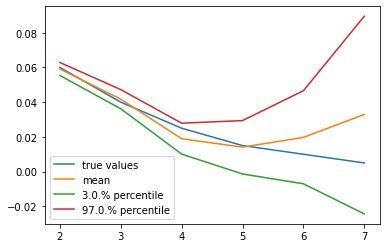

In [76]:
plot_posteriors(df_frequency_cap.index[1:], beta_plot_8.T[1:], effects[1:])

In [52]:
# Note: alternative for calculating xtilde
xtilde = np.zeros(xhat.shape)
for i in range(max_cap):
    for j in range(max_impr):
        if a_xhat[i, j] > 0 and b_xhat[i, j] > 0:
            xtilde[i, j] = stats.beta.rvs(a_xhat[i, j], b_xhat[i, j])
        elif a_xhat[i, j] > 0 and b_xhat[i, j] == 0:
            xtilde[i, j] = 1
xtilde

[[9.99989239e-01 5.53745723e-06 1.26413857e-06 8.12348488e-06
  1.57861288e-05 8.40078345e-06 8.74189865e-07]
 [9.99995845e-01 7.30569744e-01 2.40323071e-07 6.39845302e-06
  3.35318894e-05 5.25249209e-06 9.27762848e-07]
 [9.99998571e-01 7.29210223e-01 5.19608754e-01 1.16902853e-06
  1.32101755e-05 7.69419914e-06 1.43113671e-05]
 [9.99996738e-01 7.30103592e-01 5.22421057e-01 3.31684677e-01
  1.14617726e-06 1.08229473e-06 4.35014803e-06]
 [9.99986363e-01 7.29966987e-01 5.21015879e-01 3.27813692e-01
  1.88631751e-01 4.61066473e-06 2.28441285e-05]
 [9.99998059e-01 7.30527040e-01 5.18576004e-01 3.30466132e-01
  1.87654669e-01 1.09575892e-01 2.39853964e-07]
 [9.99991455e-01 7.29488357e-01 5.18483121e-01 3.29733954e-01
  1.90625963e-01 1.08230361e-01 5.00011063e-02]]


array([[1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [1.        , 0.7322136 , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [1.        , 0.7306144 , 0.52062985, 0.        , 0.        ,
        0.        , 0.        ],
       [1.        , 0.73221867, 0.52400197, 0.33202902, 0.        ,
        0.        , 0.        ],
       [1.        , 0.72983344, 0.52087233, 0.32670812, 0.19107708,
        0.        , 0.        ],
       [1.        , 0.72953164, 0.52379811, 0.33114555, 0.18967569,
        0.11046421, 0.        ],
       [1.        , 0.72669286, 0.5198746 , 0.3314446 , 0.18971119,
        0.108038  , 0.0492439 ]])

## Why does it seem to have little effect?
* The variance in $\hat{x}$ is small in comparison to the variance in $P(Y|Z)$

* How would you approach incorporating the variance of the first stage estimation?

## Recap: when to use instrumental variables
* You need to have unbiased estimates of causal effects

* You can't A/B test the treatment of interest

* You can run an A/B test something that influences the treatment of interest, but not the outcome directly

* You're sure you don't just need the results of the A/B tests

## Conclusion
* Instrumental variables can be applied to quite specific setups

* You can guaranteed unbiased estimates of causal effects for something you can't A/B test

* In this talk, I showed you how to estimate using PyMC3 following the two-stage approach

* When you run into problems with variance, you can start modelling by making parametric assumptions

* Hierachical modelling can be used to soften assumptions

* I showed my 'bootstrapping' method for taking the first stage estimation error into account. In this case, it seems to have little impact due to relatively small estimation error in the first stage in comparison to the second stage estimation.

## Questions?

In [ ]:
!jupyter nbconvert instrumental_variable_frequency_cap.ipynb --to slides --post serve

[NbConvertApp] Converting notebook instrumental_variable_frequency_cap.ipynb to slides
[NbConvertApp] Writing 1104607 bytes to instrumental_variable_frequency_cap.slides.html
[NbConvertApp] Redirecting reveal.js requests to https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.5.0
Serving your slides at http://127.0.0.1:8000/instrumental_variable_frequency_cap.slides.html
Use Control-C to stop this server
